# BAL pseudobulk analysis, pt. 4

In [1]:
import collections
import datetime
import itertools
import functools
import json
import math
import os
import sys
import pathlib

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import adjustText as adjust_text
import seaborn as sns
import goatools.base
import goatools.obo_parser
import goatools.anno.genetogo_reader
import goatools.goea.go_enrichment_ns
import pybiomart
import scipy.cluster.hierarchy
import statsmodels.stats.multitest

import matplotlib_venn
import upsetplot
import gseapy
import openpyxl

In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [4]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [5]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [6]:
plt.rcParams['figure.constrained_layout.use'] = True

In [7]:
%config InlineBackend.figure_format = "retina"

In [8]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [9]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [10]:
CLINICAL = pd.read_csv('../00clinical-v2.csv')

In [11]:
DATA_DIR = DATA / 'pseudobulk-gsva'

In [12]:
DEG_DIR = DATA / '15_pseudobulk-mmf'

List of human transcription factros from http://humantfs.ccbr.utoronto.ca/index.php

In [13]:
# TFS = pd.read_csv(
#     "http://humantfs.ccbr.utoronto.ca/download/v_1.01/TF_names_v_1.01.txt",
#     header=None
# ).iloc[:, 0]
TFS = pd.read_csv("TF_names_v_1.01.txt", header=None).iloc[:, 0]

In [14]:
HALLMARK_IFN_ALPHA_R = json.loads(
    open('HALLMARK_INTERFERON_ALPHA_RESPONSE.v2023.2.Hs.json').read()
)['HALLMARK_INTERFERON_ALPHA_RESPONSE']['geneSymbols']

In [15]:
HALLMARK_IFN_GAMMA_R = json.loads(
    open('HALLMARK_INTERFERON_GAMMA_RESPONSE.v2023.2.Hs.json').read()
)['HALLMARK_INTERFERON_GAMMA_RESPONSE']['geneSymbols']

In [16]:
def _run_go(goeaobj, genes, alpha=0.1, id2names=None):
    TMP_FILE = "__go_temp_file"
    res = goeaobj.run_study(genes, prt=None)
    res_sig = [r for r in res if r.p_fdr_bh < alpha]
    if len(res_sig) == 0:
        return None
    goeaobj.wr_tsv(TMP_FILE, res_sig, itemid2name=id2names)
    res = pd.read_table(TMP_FILE)
    res.drop(["NS", "p_uncorrected", "study_count"], axis=1, inplace=True)
    os.unlink(TMP_FILE)
    return res


def run_go(degs, background):
    obo_file = goatools.base.download_go_basic_obo(prt=None)
    ass_file = goatools.base.download_ncbi_associations(prt=None)
    obodag = goatools.obo_parser.GODag(obo_file, prt=None)
    objanno = goatools.anno.genetogo_reader.Gene2GoReader(ass_file, prt=None)
    go_ns = {}
    go_ns["BP"] = objanno.get_ns2assc(prt=None)["BP"]
    dataset = pybiomart.Dataset(name='hsapiens_gene_ensembl', host='http://oct2014.archive.ensembl.org/')
    genes = dataset.query(attributes=['entrezgene', 'external_gene_name'])
    genes.columns = ["entrez_id", "symbol"]
    genes.set_index("symbol", inplace=True)
    genes = genes.loc[~genes.index.duplicated(), :]
    genes.dropna(inplace=True)
    genes.entrez_id = genes.entrez_id.astype(int)
    id2names = genes.reset_index().set_index("entrez_id").symbol.to_dict()
    degs = pd.Series(degs)
    degs = degs[degs.isin(genes.index)]
    background = pd.Series(background)
    background = background.loc[background.isin(genes.index)]
    goeaobj = goatools.goea.go_enrichment_ns.GOEnrichmentStudyNS(
        genes.reindex(background).entrez_id,
        go_ns,
        obodag,
        propagate_counts=False,
        alpha=0.1,
        methods=["fdr_bh"],
        log=None
    )
    degs = genes.reindex(degs).entrez_id
    if degs.size > 0:
        go_upreg = _run_go(goeaobj, degs, alpha=0.1, id2names=id2names)
    return go_upreg

In [17]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [18]:
def get_cell_type_from_slug(slug: str, ds: sc.AnnData) -> str:
    for cell_type in ds.obs.cell_type.unique():
        cell_type_slug = cell_type.replace(" ", "_").replace("/", "_")
        if slug == cell_type_slug:
            return cell_type
    raise ValueError(f"Cannot find cluster for {slug}")

In [19]:
MODEL = 'degs'

def load_cell_type_info(folder, data_folder):
    name = folder.name
    degs = pd.read_csv(folder / MODEL / 'degs.csv', index_col=0)
    degs_filt = pd.read_csv(folder / MODEL / 'degs-filt.csv', index_col=0)
    expr = pd.read_table(data_folder / 'data' / f'{name}.txt', index_col=0)
    gene_cells = pd.read_table(data_folder / 'data' / f'{name}-n_cells.txt', index_col=0)
    meta = pd.read_csv(folder / 'meta.csv', index_col=0)

    go_ctrl = folder / MODEL / 'go-naive.csv'
    if go_ctrl.exists():
        go_ctrl = pd.read_csv(go_ctrl, index_col=0)
    else:
        go_ctrl = None

    go_ssc = folder / MODEL / 'go-mmf.csv'
    if go_ssc.exists():
        go_ssc = pd.read_csv(go_ssc, index_col=0)
    else:
        go_ssc = None

    # ensure we operate on filtered samples
    gene_cells = gene_cells.loc[:, meta["External Sample ID"]]
    gene_cells = gene_cells.loc[gene_cells.sum(axis=1) > 0, :]

    return {
        'degs': degs,
        'filtered_degs': degs_filt,
        'meta': meta,
        'gene_cells': gene_cells,
        'expr': expr,
        'go_naive': go_ctrl,
        'go_mmf': go_ssc,
    }


def process_cell_type(folder, data_folder):
    info = {}

    clust = get_cell_type_from_slug(folder.name, ds_processed)
    info.update(load_cell_type_info(folder, data_folder))

    return info

In [20]:
data = {}

for folder in sorted(DEG_DIR.iterdir()):
    if not folder.is_dir():
        continue
    if not (folder / MODEL).exists():
        continue
    if folder.name == 'global':
        continue
    data[folder.name] = process_cell_type(folder, DATA_DIR / folder.name)

In [21]:
data = {
    k.replace('_', ' ')\
        .replace('MoAM-3 mature', 'MoAM-2')\
        .replace('MoAM-4', 'MoAM-3')\
        .replace('Perivascular', 'Interstitial'): v
    for k, v in data.items()
}

In [22]:
ds_processed.obs.cell_type = ds_processed.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

# 1. Pseudobulk for MMF status

This comparison is done across V2 and V3 chemistry together

## 1.1 Number of samples per comparison

Maximum number of MMF samples: 4
Maximum number of Naive samples: 6

In [23]:
rows = []
for k, v in data.items():
    meta = v['meta']
    rows.append([k] + meta.mmf.value_counts().sort_index().tolist())
df = pd.DataFrame(rows, columns=["cell_type", "n_mmf_samples", "n_naive_samples"])
df.sort_values('cell_type')

cell_type  n_mmf_samples  n_naive_samples
0                     B cells              2                6
1                    CCR7+ DC              2                3
2               CD4 TEM cells              3                5
3           CD4 naive T cells              2                5
4               CD8 TEM cells              2                2
5               CD8 TRM cells              3                4
6                         DC1              2                5
7                         DC2              4                6
12   Interstitial macrophages              4                6
8                      MoAM-1              4                6
9                      MoAM-2              4                6
10         MoAM-3 profibrotic              4                6
11                  Monocytes              4                6
13  Proliferating macrophages              4                6
14                     TRAM-1              4                6
15                     TRAM-2              4                5
16                     TRAM-3              4                6
17                     TRAM-4              4                6
18                TRAM-5 MT1G              4                6
19           TRAM-6 activated              4                6
20                      Tregs              2                3

## 1.2 Check number of samples and cells per status per cluster

In [24]:
n_cells_data = {}
for cell_type, info in data.items():
    n_cells_sample = {}
    for i, row in info["meta"].iterrows():
        sample = row['External Sample ID']
        status = row['mmf']
        n_cells = row['n_cells']
        n_cells_sample[(status, sample)] = n_cells
    n_cells_data[cell_type] = n_cells_sample

In [25]:
pd.DataFrame.from_dict(n_cells_data, orient="index").loc[:, ["Naive", "MMF"]].sort_index()

Naive                                       \
                          SSc_SSc6 SSc_SSc8 SSc_SSc9 SSc_SSc10 SSc_SSc7   
B cells                      327.0    522.0    193.0      64.0     67.0   
CCR7+ DC                       NaN     82.0    209.0      61.0      NaN   
CD4 TEM cells                430.0    772.0      NaN     103.0    303.0   
CD4 naive T cells             63.0    117.0      NaN      65.0     70.0   
CD8 TEM cells                  NaN    147.0      NaN      81.0      NaN   
CD8 TRM cells                182.0     72.0      NaN     178.0      NaN   
DC1                          107.0    389.0    128.0       NaN    472.0   
DC2                           95.0    162.0   1085.0     316.0    354.0   
Interstitial macrophages     309.0    267.0    545.0     131.0    257.0   
MoAM-1                       311.0    403.0    449.0     513.0    355.0   
MoAM-2                       484.0    995.0    470.0    1136.0   1925.0   
MoAM-3 profibrotic            80.0    169.0   1103.0     317.0    224.0   
Monocytes                    150.0    289.0   1170.0     340.0    435.0   
Proliferating macrophages    870.0    428.0    148.0     525.0   2243.0   
TRAM-1                       209.0    710.0    283.0    2133.0   5930.0   
TRAM-2                      3902.0      NaN     51.0     550.0   4381.0   
TRAM-3                        89.0    384.0    158.0     686.0   1433.0   
TRAM-4                       298.0     96.0     84.0     581.0    945.0   
TRAM-5 MT1G                  565.0    166.0     55.0     381.0    947.0   
TRAM-6 activated             549.0    404.0    187.0     490.0   1420.0   
Tregs                          NaN    143.0      NaN      89.0      NaN   

                                         MMF                                
                          SSc_SSc4 SSc_SSc12 SSc_SSc13 SSc_SSc14 SSc_SSc15  
B cells                       54.0      56.0        58       NaN       NaN  
CCR7+ DC                       NaN      65.0       115       NaN       NaN  
CD4 TEM cells                290.0     251.0       122     296.0       NaN  
CD4 naive T cells            250.0     226.0        71       NaN       NaN  
CD8 TEM cells                  NaN       NaN        56      69.0       NaN  
CD8 TRM cells                319.0     434.0        85     690.0       NaN  
DC1                           67.0     148.0       172       NaN       NaN  
DC2                          117.0     285.0       574     151.0     152.0  
Interstitial macrophages      69.0     206.0       534     355.0     530.0  
MoAM-1                       164.0     533.0       654     221.0     423.0  
MoAM-2                       286.0     841.0      1545     496.0     832.0  
MoAM-3 profibrotic            78.0     477.0      1223     397.0     523.0  
Monocytes                    128.0     730.0      1257     246.0     334.0  
Proliferating macrophages    352.0     579.0       834     369.0     455.0  
TRAM-1                       359.0    1846.0      1201    1645.0    2674.0  
TRAM-2                      1194.0     185.0       264     334.0    1055.0  
TRAM-3                        94.0     819.0       381     566.0    1444.0  
TRAM-4                       191.0     579.0       163     200.0     353.0  
TRAM-5 MT1G                  178.0     327.0       316     258.0     213.0  
TRAM-6 activated             224.0     742.0       348     410.0     343.0  
Tregs                         57.0      62.0        76       NaN       NaN

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.draw()
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(**tight_params)


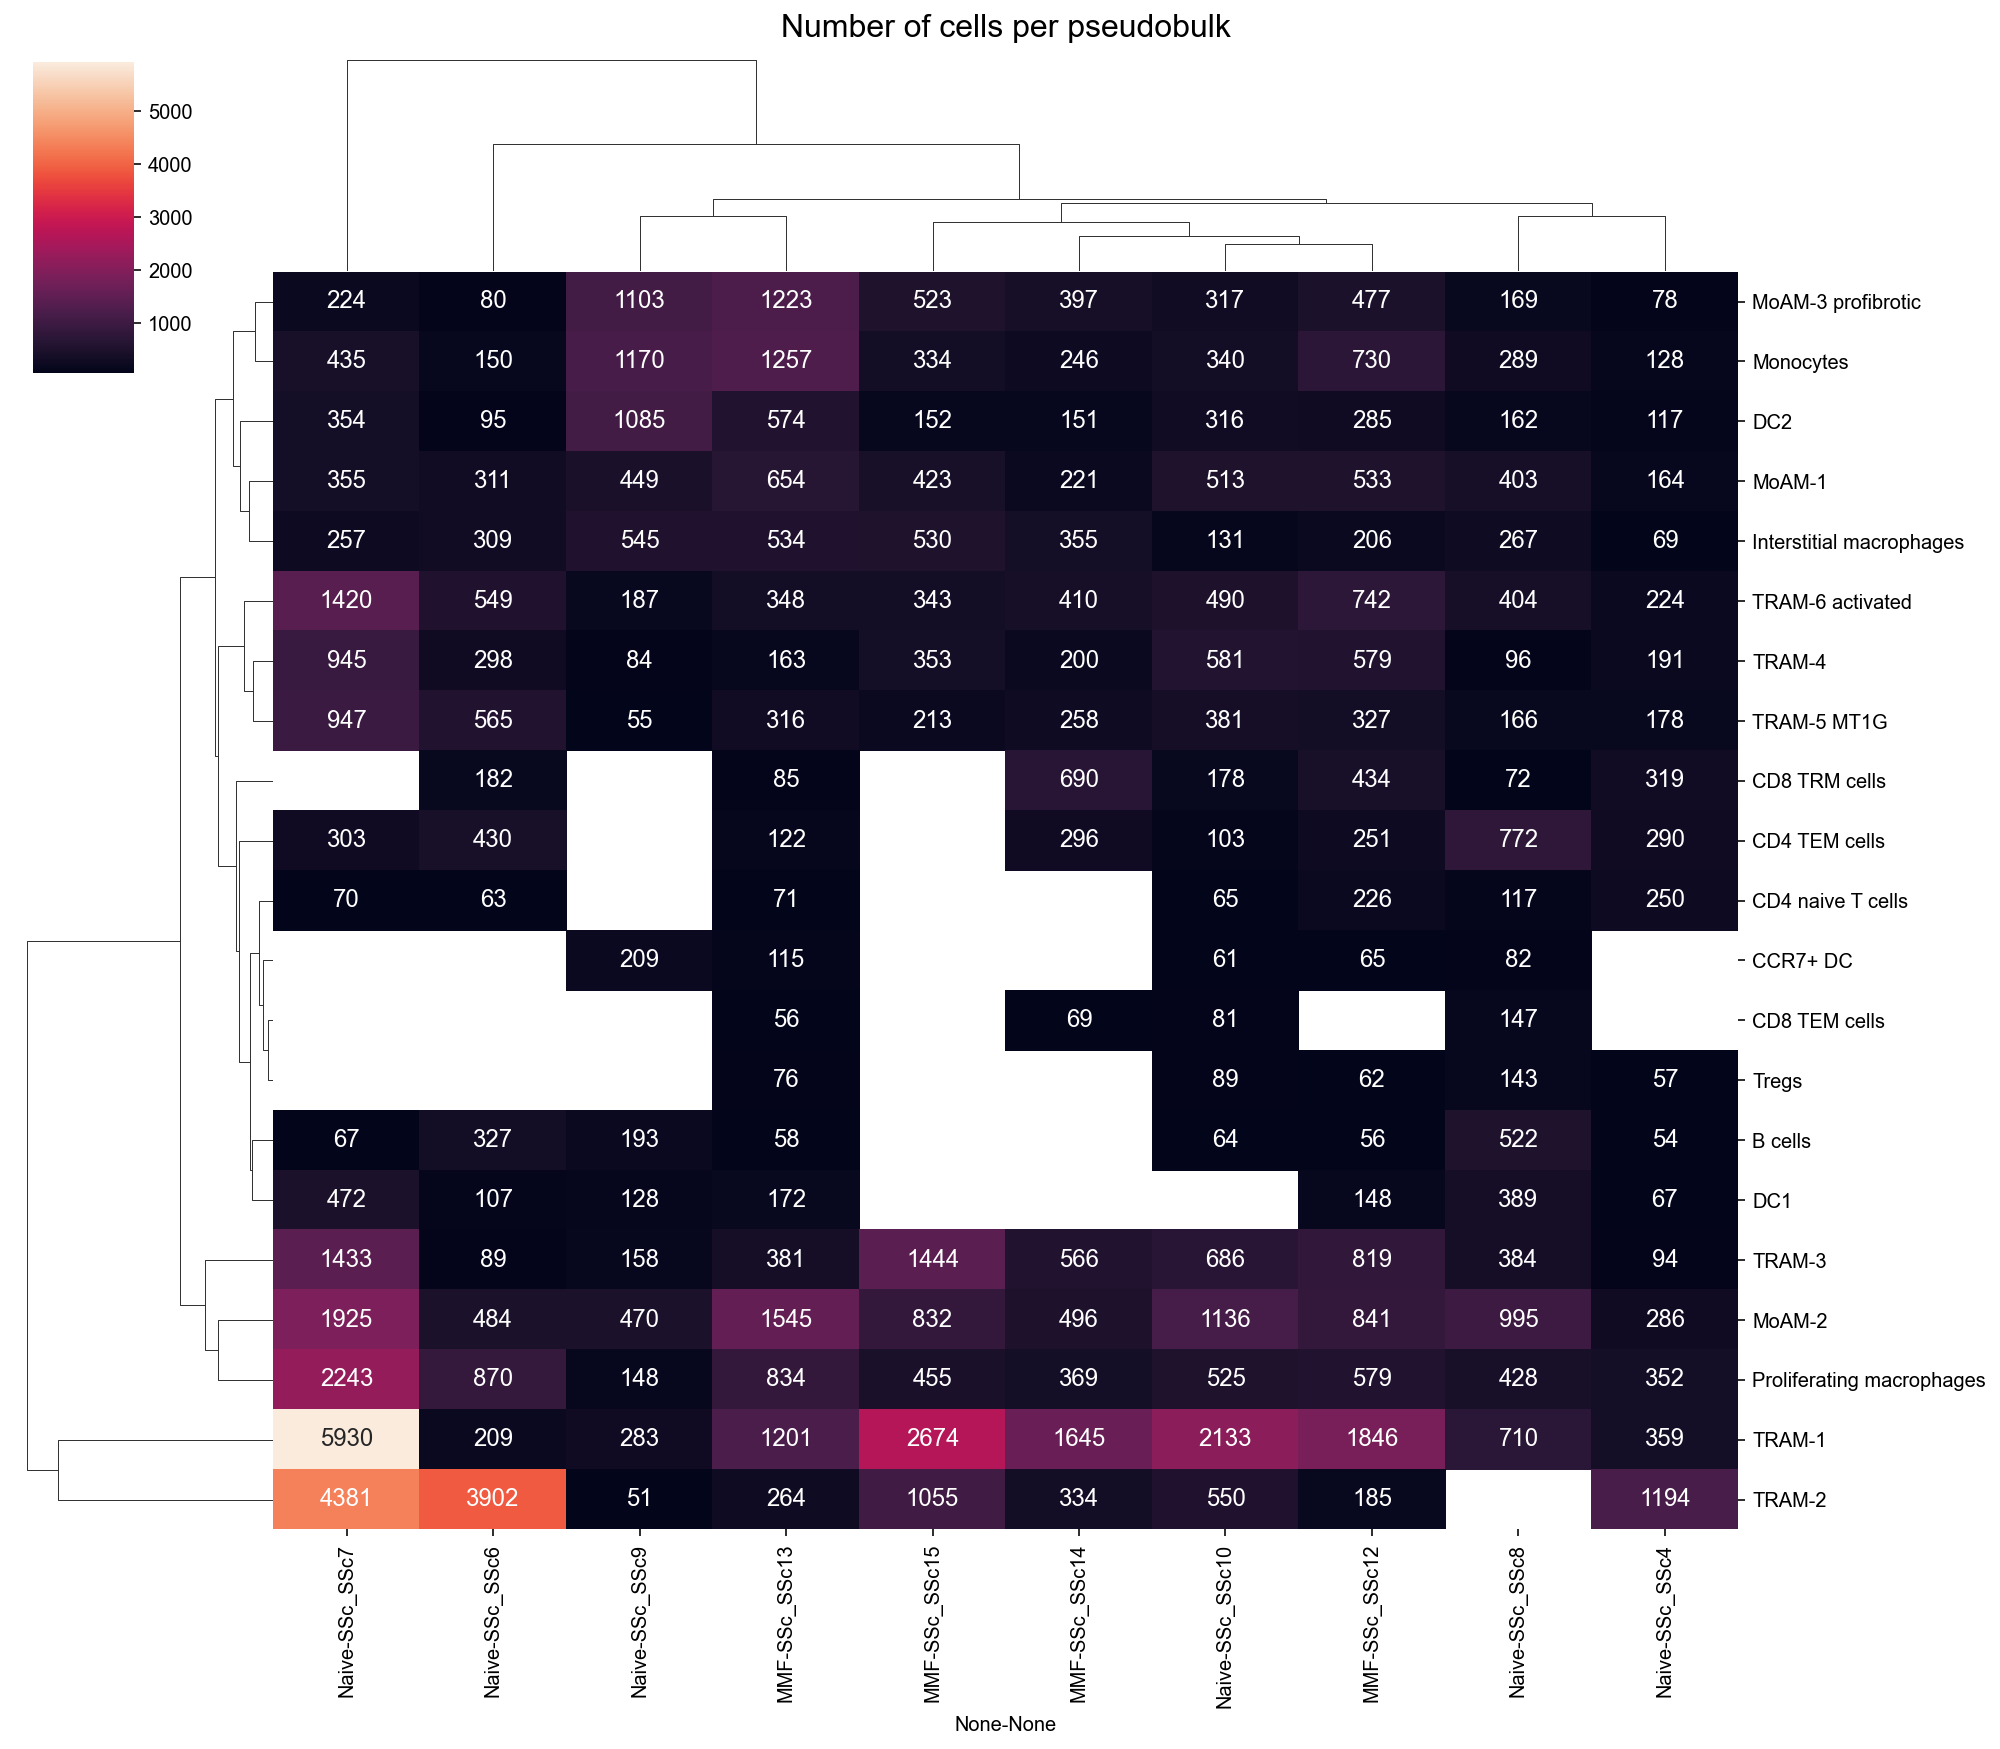

In [26]:
n_cells_per_pseudobulk = pd.DataFrame.from_dict(
    n_cells_data, orient="index"
).loc[:, ["Naive", "MMF"]].fillna(0)
cg = sns.clustermap(
    n_cells_per_pseudobulk,
    figsize=(14, 12),
    dendrogram_ratio=0.15,
    annot=True,
    fmt='.0f',
    annot_kws=dict(
        size=12
    ),
    mask=n_cells_per_pseudobulk == 0
)
cg.ax_col_dendrogram.set_title('Number of cells per pseudobulk', size=16);

## 1.3 Return number of filtered DEGs for each cluster

In [27]:
CT_ORDER = [
    'Monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',

    'TRAM-1',
    'TRAM-2',
    'TRAM-3',
    'TRAM-4',
    'TRAM-5 MT1G',
    'TRAM-6 activated',

    'Interstitial macrophages',
    'Proliferating macrophages',

    'CD4 TEM cells',
    'CD4 naive T cells',
    'Tregs',
    'CD8 TEM cells',
    'CD8 TRM cells',

    'DC1',
    'DC2',
    'B cells',
    'CCR7+ DC',
]

In [28]:
rows = []
for k, v in data.items():
    degs = v["filtered_degs"]
    n_degs = degs.sign.notna().sum()
    rows.append((k, n_degs))
df = pd.DataFrame(rows, columns=["name", "n_degs"])

In [29]:
df.name = pd.Categorical(df.name, categories=CT_ORDER)

In [30]:
df.sort_values("name")

name  n_degs
11                  Monocytes     429
8                      MoAM-1     444
9                      MoAM-2     494
10         MoAM-3 profibrotic     345
14                     TRAM-1     716
15                     TRAM-2     423
16                     TRAM-3     414
17                     TRAM-4     366
18                TRAM-5 MT1G     376
19           TRAM-6 activated     484
12   Interstitial macrophages     274
13  Proliferating macrophages     448
2               CD4 TEM cells     145
3           CD4 naive T cells       3
20                      Tregs       0
4               CD8 TEM cells       1
5               CD8 TRM cells      16
6                         DC1     111
7                         DC2     269
0                     B cells       3
1                    CCR7+ DC       6

## 1.5 Plot number of filtered DEGs for each cluster

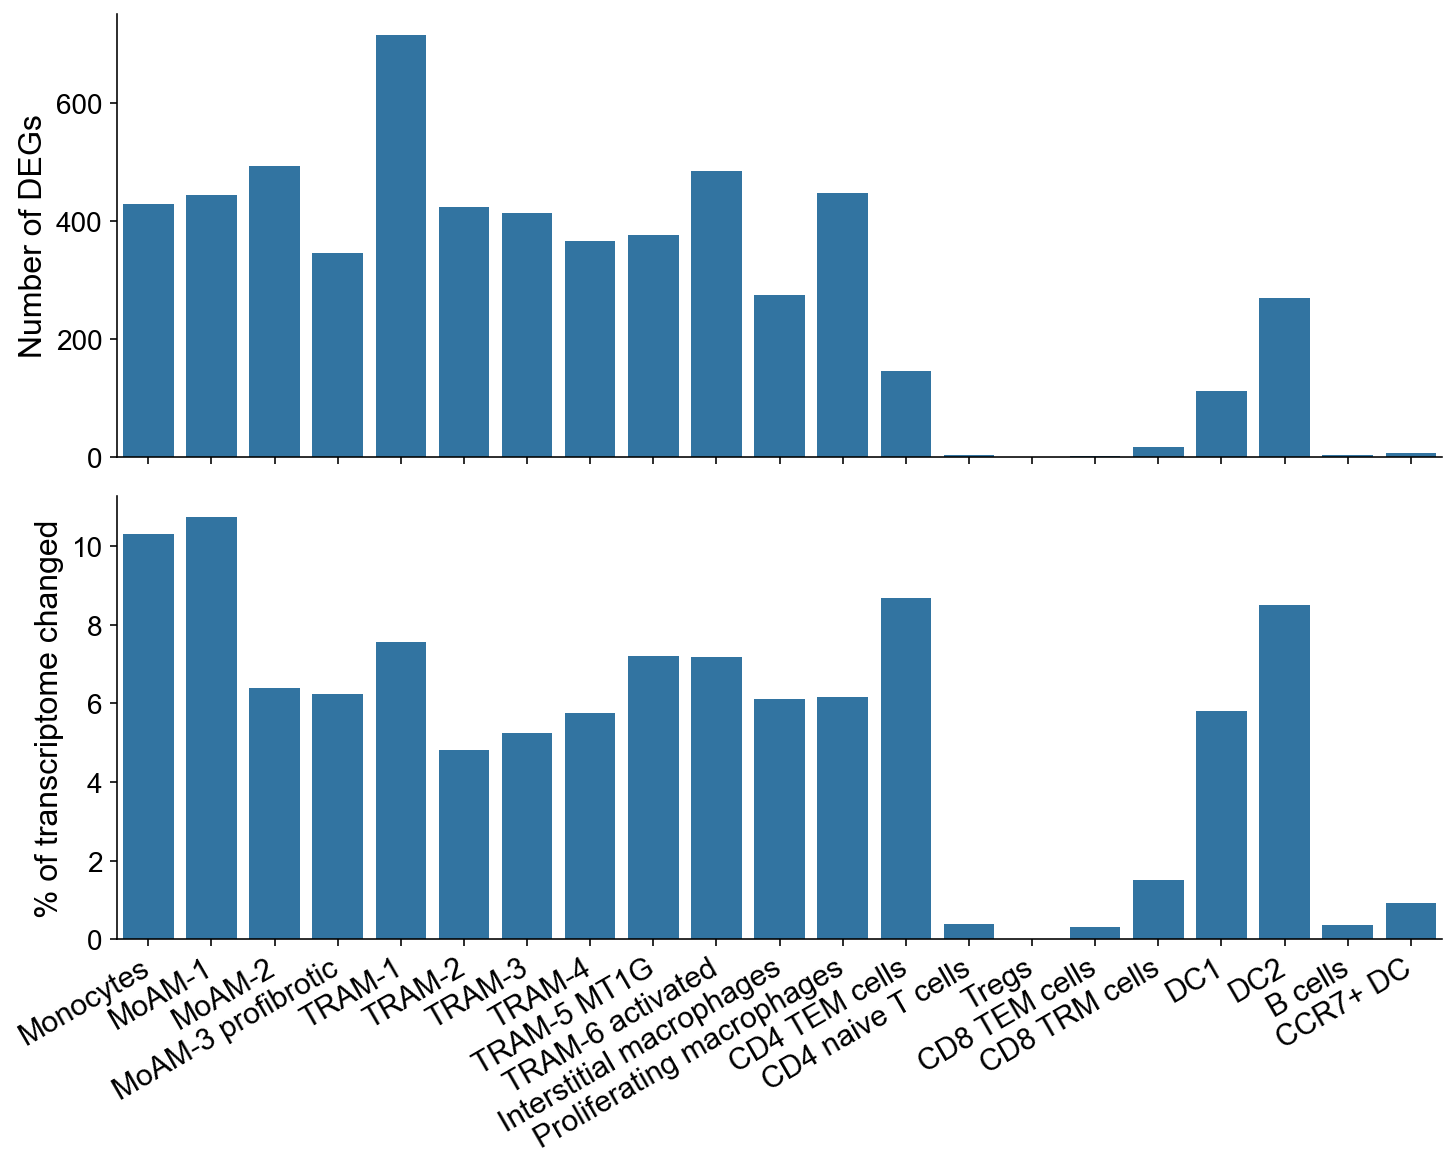

In [31]:
fig, axes = plt.subplots(figsize=(10, 8), constrained_layout=True, nrows=2, sharex=True)
ax = axes[0]
sns.barplot(
    data=df.sort_values('name'),
    y="n_degs",
    x="name",
    ax=ax,
    palette=['tab:blue']
)
ax.set_xticklabels(
    df.sort_values('name').name,
    rotation=30,
    ha="right",
    fontsize=15
)
ax.set_ylabel("Number of DEGs", fontsize=16)
ax.set_xlabel("")
ax.tick_params(axis='y', labelsize=14)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.spines['top'].set_visible(None)
ax.spines['right'].set_visible(None)

ax = axes[1]
rows = []
for k, v in data.items():
    degs = v["filtered_degs"]
    n_degs = degs.sign.notna().sum() / degs.shape[0] * 100
    rows.append((k, n_degs))
df = pd.DataFrame(rows, columns=["name", "n_degs"])
df.name = pd.Categorical(df.name, categories=CT_ORDER)

sns.barplot(
    data=df.sort_values('name'),
    y="n_degs",
    x="name",
    # log=True,
    ax=ax,
    palette=['tab:blue']
)
ax.set_xticklabels(
    df.sort_values('name').name,
    rotation=30,
    ha="right",
    fontsize=15
)
ax.set_ylabel("% of transcriptome changed", fontsize=16)
ax.set_xlabel("")
ax.tick_params(axis='y', labelsize=14)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.spines['top'].set_visible(None)
ax.spines['right'].set_visible(None)

fig.savefig('00_figures/Figure_S3A_nDEGs_pct_DEGs_myco.pdf')

Save table as excel with multiple sheets

In [39]:
wb = openpyxl.Workbook()
for ct in CT_ORDER:
    if ct not in data:
        continue
    info = data[ct]
    degs = info['filtered_degs']
    ws = wb.create_sheet(title=ct)
    ws.append(['gene'] + list(degs.columns))
    for i, row in degs.iterrows():
        ws.append([i] + list(row))


In [40]:
del wb['Sheet']  # remove default sheet
wb.save('00_figures/Table_S7_myco_vs_not_all_degs.xlsx')

## 1.6 Plot number of GOs for each cluster

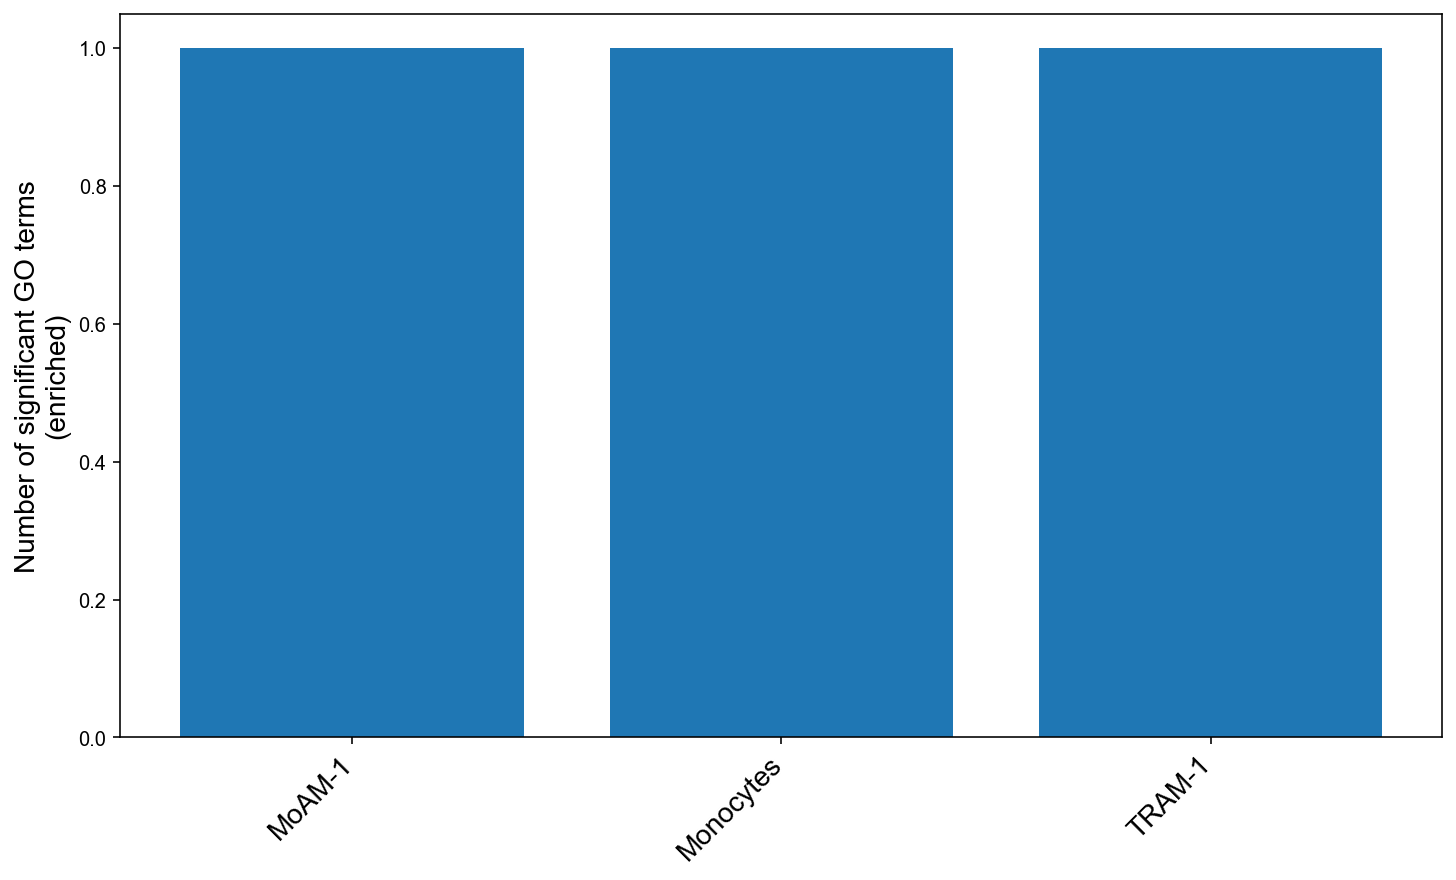

In [ ]:
n_gos = []
clusters = []
for c, i in data.items():
    n = 0
    go_upreg = i['go_naive']
    if go_upreg is not None:
        n += int(go_upreg.enrichment.eq('e').sum())
    go_downreg = i['go_mmf']
    if go_downreg is not None:
        n += int(go_downreg.enrichment.eq('e').sum())

    if n > 0:
        clusters.append(c)
        n_gos.append(n)

df = pd.DataFrame(dict(name=clusters, n_gos=n_gos))
df = df.sort_values("name")

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(list(range(df.name.size)), df.n_gos)

ax.set_xticks(list(range(df.name.size)))
ax.set_xticklabels(
    df.name,
    rotation=45,
    ha="right",
    fontsize=14
)
ax.set_ylabel("Number of significant GO terms\n(enriched)", fontsize=14)

trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

## 1.7 Return number of GOs for each cluster

In [34]:
df

name  n_gos
0     MoAM-1      1
1  Monocytes      1
2     TRAM-1      1

## 1.8 Plot MA for CD4 TEM cells

In [29]:
def plot_ma(filtered_degs, gene_cells, title, genes, ylim=None, ticks=None):
    YLIM = 3.85
    if ylim is not None:
        YLIM = ylim
    if ticks is None:
        ticks = [250, 500, 750, 1000, 1500, 2000]

    fig, ax = plt.subplots(figsize=(8, 6))
    filtered_degs = filtered_degs.copy()
    filtered_degs.sign.fillna('', inplace=True)
    val_counts = filtered_degs.sign.value_counts(dropna=False).sort_index()
    num_top = min(10, val_counts.get("Up in Naive", 0))
    num_bot = min(10, val_counts.get("Up in MMF", 0))

    sign_cells = gene_cells.loc[filtered_degs.index[filtered_degs.sign != ""], :].sum(axis=1)
    min_cells = sign_cells.min()
    max_cells = sign_cells.max()
    colors = {
        "": "gray",
        "Up in Naive": lambda x: gene_cells.loc[x.index, :].sum(axis=1),
        "Up in MMF": lambda x: gene_cells.loc[x.index, :].sum(axis=1),
    }
    cmap = {
        "": None,
        "Up in Naive": mpl.cm.winter_r,
        "Up in MMF": mpl.cm.autumn_r,
    }
    alphas = {
        "": 0.2,
        "Up in Naive": 1,
        "Up in MMF": 1
    }
    processed = []
    labels = {}
    for k, v in val_counts.items():
        idx = filtered_degs.sign == k
        kwargs = {}
        label = k
        if label:
            if label == 'Up in Naive':
                label = 'Up in no current myco'
            else:
                label = 'Up in current myco'
            label = f"{label} ($n={idx.sum()}$)"
            labels[k] = label
        kwargs["label"] = label
        c = colors[k]
        if callable(c):
            c = c(filtered_degs[idx])
            kwargs["norm"] = mpl.colors.LogNorm(vmin=min_cells, vmax=max_cells)
        kwargs["c"] = c
        kwargs["alpha"] = alphas[k]
        if cmap.get(k):
            kwargs["cmap"] = cmap[k]
        dots = ax.scatter(
            filtered_degs.baseMean[idx],
            filtered_degs.log2FoldChange[idx],
            s=6,
            **kwargs
        )
        if YLIM > 0:
            outliers = filtered_degs.loc[idx & filtered_degs.log2FoldChange.gt(YLIM)]
            if outliers.shape[0] > 0:
                c = colors[k]
                kwargs = dict()
                if callable(c):
                    c = colors[k](outliers)
                    kwargs['norm'] = mpl.colors.LogNorm(vmin=min_cells, vmax=max_cells)
                if cmap.get(k):
                    kwargs["cmap"] = cmap[k]
                ax.scatter(
                    outliers.baseMean,
                    YLIM - 0.1,
                    s=12,
                    c=c,
                    marker='^',
                    **kwargs
                )
        else:
            outliers = filtered_degs.loc[idx & filtered_degs.log2FoldChange.lt(YLIM)]
            if outliers.shape[0] > 0:
                c = colors[k]
                kwargs = dict()
                if callable(c):
                    c = colors[k](outliers)
                    kwargs['norm'] = mpl.colors.LogNorm(vmin=min_cells, vmax=max_cells)
                if cmap.get(k):
                    kwargs["cmap"] = cmap[k]
                ax.scatter(
                    outliers.baseMean,
                    YLIM + 0.1,
                    s=12,
                    c=c,
                    marker='v',
                    **kwargs
                )
        if kwargs.get("norm"):
            cbar = fig.colorbar(
                dots,
                label="Number of cells expressing a gene"
            )
            cbar.set_ticks(ticks, update_ticks=True)
            cbar.set_ticklabels([str(t) for t in ticks])
            cbar.minorticks_off()
            processed.append(k)
    texts = []
    for r in filtered_degs.loc[genes, :].itertuples(name=None):
        texts.append(ax.text(r[1], r[2], r[0], size=9, style='italic'))
    ax.set_xscale("log")
    ax.set_title(title)
    ax.set_ylabel("$log_2$(fold change)", size=16)
    ax.set_xlabel("Average normalized expression", size=16)
    CMAP_IDX = 0.7
    ax.legend(
        handles=[
            mpl.lines.Line2D(
                [0], [0], marker='o', markersize=6,
                markeredgecolor=mpl.cm.winter_r(CMAP_IDX),
                markerfacecolor=mpl.cm.winter_r(CMAP_IDX), linestyle=''
            ),
            mpl.lines.Line2D(
                [0], [0], marker='o', markersize=6,
                markeredgecolor=mpl.cm.autumn_r(CMAP_IDX),
                markerfacecolor=mpl.cm.autumn_r(CMAP_IDX), linestyle=''
            ),
            mpl.lines.Line2D(
                [0], [0], marker='o', markersize=6,
                markeredgecolor='gray',
                markerfacecolor='gray', linestyle=''
            )
        ],
        labels=[
            labels['Up in Naive'],
            labels['Up in MMF'],
            'Not significant'
        ],
        fontsize=12
    )

    if YLIM < 0:
        ax.set_ylim(YLIM, ax.get_ylim()[1])
    else:
        ax.set_ylim(ax.get_ylim()[0], YLIM)
    ax.xaxis.set_minor_formatter(lambda x, y: x in (50, 500, 5000) and f'{x:.0f}' or '')
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
    fig.axes[0].set_position((0.1, 0.1, 0.72, 0.85))
    for i, d in enumerate(processed):
        if d == "Up in MMF":
            fig.axes[i + 1].set_position((0.84, 0.1, 0.02, 0.375))
        else:
            fig.axes[i + 1].set_position((0.84, 0.55, 0.02, 0.375))
    adjust_text.adjust_text(
        texts,
        x=filtered_degs.baseMean.values,
        y=filtered_degs.log2FoldChange.values,
        ax=ax,
        autoalign=False,
        expand_points=(1.2, 1.2),
        force_points=(1, 1),
        arrowprops=dict(arrowstyle='-', color='black', shrinkA=4, shrinkB=4)
    )
    ax.collections[0].set_rasterized(True)
    return fig

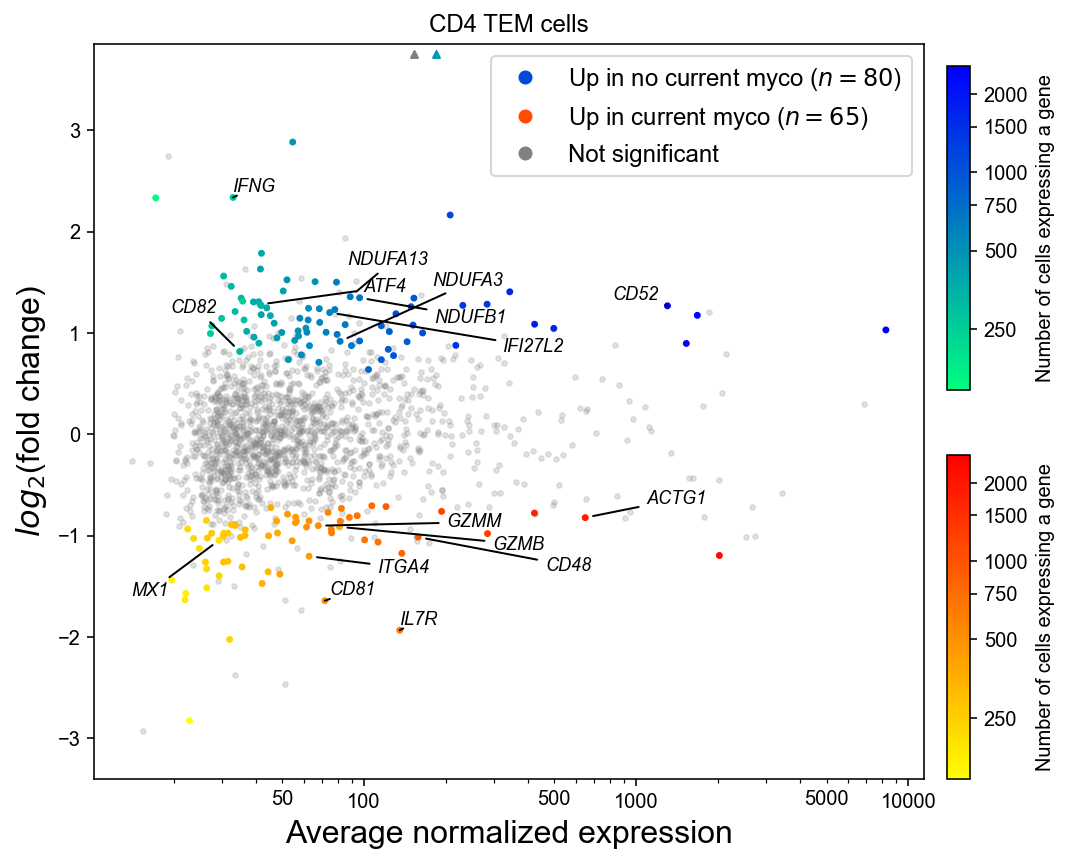

In [30]:
CT = 'CD4 TEM cells'
# data[CT].keys()
fig = plot_ma(
    data[CT]['filtered_degs'],
    data[CT]['gene_cells'],
    CT,
    ['IFNG', 'IFI27L2', 'NDUFA13', 'ATF4', 'CD52', 'NDUFA3', 'CD82', 'IL7R', 'CD81', 'ACTG1',
     'NDUFB1', 'ITGA4', 'CD48', 'MX1', 'GZMB', 'GZMM']
);
fig.savefig('00_figures/Figure_3C_cd4_tem_degs.pdf', dpi=300)

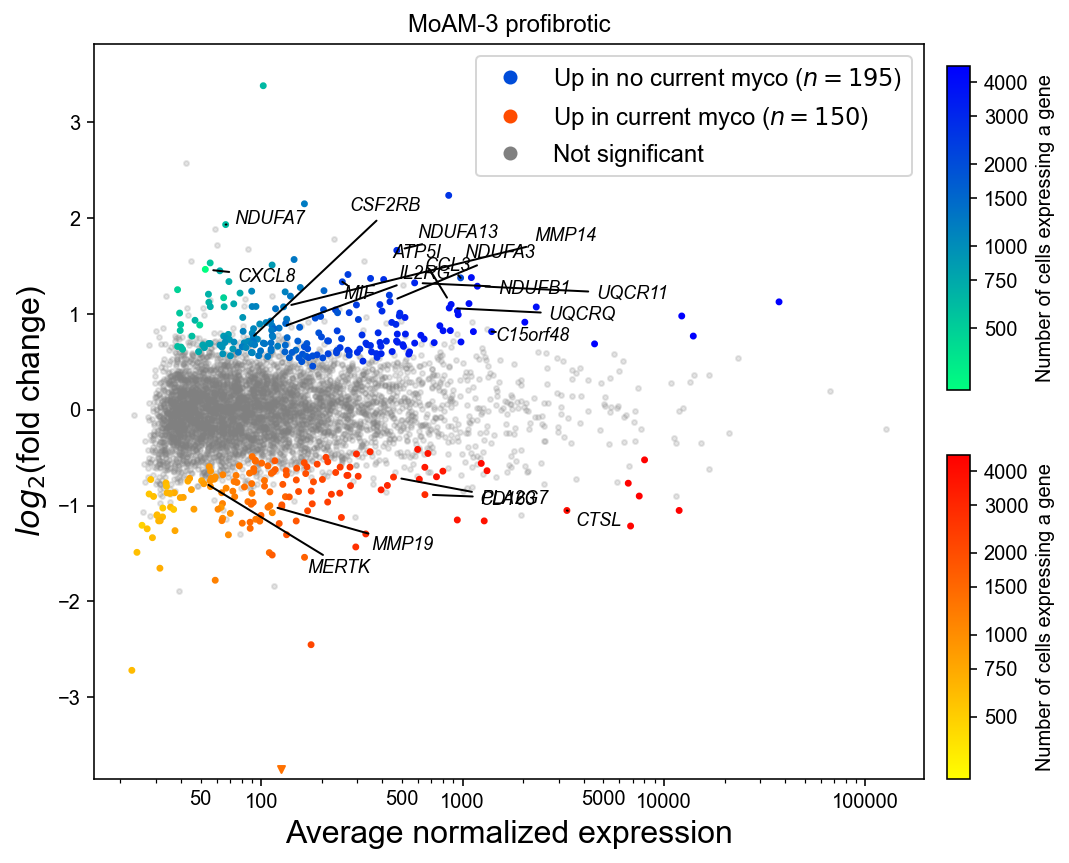

In [32]:
CT = 'MoAM-3 profibrotic'
# data[CT].keys()
fig = plot_ma(
    data[CT]['filtered_degs'],
    data[CT]['gene_cells'],
    CT,
    ['NDUFA7', 'NDUFA13', 'NDUFB1', 'NDUFA3', 'UQCR11', 'CXCL8', 'CCL3', 'UQCRQ',
     'ATP5I', 'MIF', 'MMP14', 'C15orf48', 'IL2RG', 'CSF2RB',
     'PLA2G7', 'MMP19', 'MERTK', 'CTSL', 'CD163'],
    ylim=-3.85,
    ticks=[500, 750, 1000, 1500, 2000, 3000, 4000]
);
fig.savefig('00_figures/Figure_3D_moam_3_degs.pdf', dpi=300)

In [33]:
data[CT]['filtered_degs']

baseMean  log2FoldChange     lfcSE      stat        pvalue  \
C1orf56    102.363980        3.381280  0.541719  6.241764  4.326623e-10   
FOLR3       42.552575        2.571868  1.016523  2.530063  1.140420e-02   
CRIP1      853.087136        2.236926  0.533288  4.194592  2.733627e-05   
GABARAP    163.899118        2.149017  0.562669  3.819329  1.338152e-04   
NDUFA7      66.608407        1.932008  0.358392  5.390776  7.015405e-08   
...               ...             ...       ...       ...           ...   
MTRNR2L8   115.229168       -1.837957  0.896172 -2.050897  4.027695e-02   
TPGS1       39.231926       -1.893334  0.705496 -2.683693  7.281395e-03   
MTRNR2L12  176.851016       -2.452513  0.805331 -3.045348  2.324111e-03   
HIST1H1E    22.789785       -2.720117  0.759184 -3.582949  3.397371e-04   
HLA-DQA2   125.223405       -5.285686  1.432556 -3.689690  2.245278e-04   

               padj         sign  
C1orf56    0.000002  Up in Naive  
FOLR3      0.111503          NaN  
CRIP1      0.002856  Up in Naive  
GABARAP    0.006857  Up in Naive  
NDUFA7     0.000065  Up in Naive  
...             ...          ...  
MTRNR2L8   0.209899          NaN  
TPGS1      0.085735          NaN  
MTRNR2L12  0.041926    Up in MMF  
HIST1H1E   0.012451    Up in MMF  
HLA-DQA2   0.009861    Up in MMF  

[5534 rows x 7 columns]

In [62]:
data[CT]['filtered_degs'].loc[['PLA2G7', 'CD163']]

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj  \
PLA2G7  649.927803       -0.886226  0.292554 -3.029277  0.002451  0.043903   
CD163   453.895388       -0.703281  0.174828 -4.022696  0.000058  0.004303   

             sign  
PLA2G7  Up in MMF  
CD163   Up in MMF

# 2. Common DEGs between T cells and Macrophages

In [223]:
trams = list(filter(lambda x: x.startswith("TRAM"), data.keys()))

In [224]:
common_degs = {'naive': {}, 'mmf': {}}

In [ ]:
for ct in trams:
    degs = data[ct]['filtered_degs']
    degs_control = degs.index[degs.sign.eq('Up in Naive')].tolist()
    degs_ssc = degs.index[degs.sign.eq('Up in MMF')].tolist()

    if ct not in common_degs['naive']:
        common_degs['naive']['TRAM common'] = degs_control
    common_degs['naive']['TRAM common'] = np.intersect1d(
        common_degs['naive']['TRAM common'],
        degs_control
    )

    if ct not in common_degs['mmf']:
        common_degs['mmf']['TRAM common'] = degs_ssc
    common_degs['mmf']['TRAM common'] = np.intersect1d(
        common_degs['mmf']['TRAM common'],
        degs_ssc
    )

In [226]:
other_cell_types = (
    list(filter(lambda x: x.startswith("MoAM"), data.keys()))
    + ['Monocytes', 'Interstitial macrophages', 'CD4 TEM cells', 'DC2', 'DC1']
)

In [227]:
for ct in other_cell_types:
    degs = data[ct]['filtered_degs']
    common_degs['naive'][ct] = degs.index[degs.sign.eq('Up in Naive')].tolist()
    common_degs['mmf'][ct] = degs.index[degs.sign.eq('Up in MMF')].tolist()

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


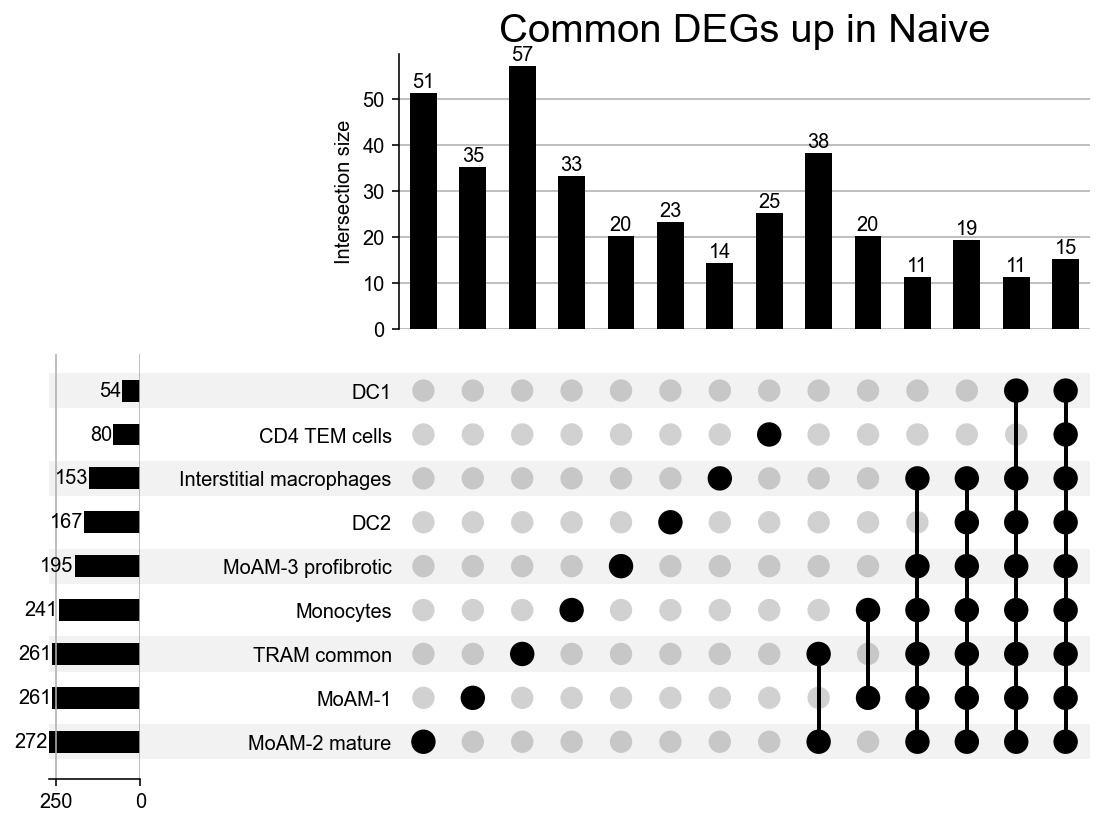

In [252]:
upset_plot_data = upsetplot.from_contents(common_degs['naive'])
p = upsetplot.UpSet(
    upset_plot_data,
    show_counts=True,
    min_subset_size=10
).plot()
p['intersections'].set_title('Common DEGs up in Naive', size=20);

### Plot % unique DEGs per cell type

In [253]:
plot_df = []
for i, ct in enumerate(upset_plot_data.index.names):
    uniq_idx = [False] * len(upset_plot_data.index.names)
    uniq_idx[i] = True
    uniq_idx = tuple(uniq_idx)
    n_uniq = upset_plot_data.loc[uniq_idx].shape[0]
    n_total = np.sum(upset_plot_data.index.get_level_values(i))
    plot_df.append([ct, n_uniq, n_total])
plot_df = pd.DataFrame(plot_df, columns=['cell_type', 'n_uniq', 'n_total'])
plot_df['pct_uniq'] = plot_df.n_uniq / plot_df.n_total * 100

<ipython-input-253-046292912372>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  n_uniq = upset_plot_data.loc[uniq_idx].shape[0]


In [ ]:
CT_ORDER = [
    'Monocytes',
    'MoAM-1',
    'MoAM-2 mature',
    'MoAM-3 profibrotic',

    'TRAM common',

    'Interstitial macrophages',

    'CD4 TEM cells',

    'DC1',
    'DC2'
]
plot_df.cell_type = pd.Categorical(plot_df.cell_type, categories=CT_ORDER)

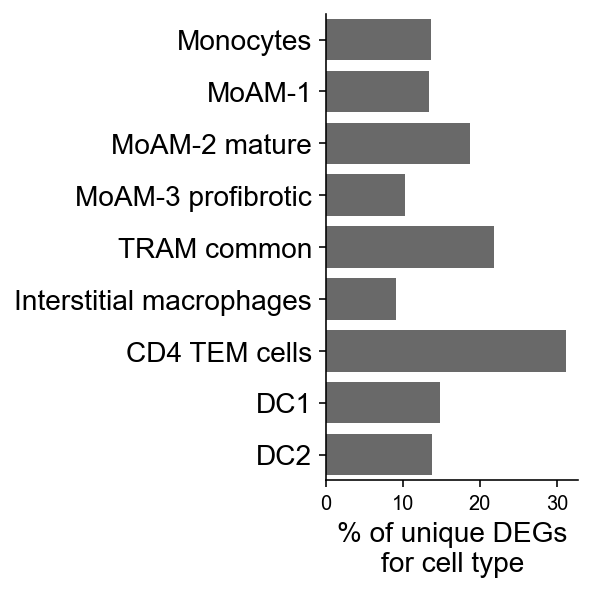

In [255]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
sns.barplot(
    data=plot_df,
    y='cell_type',
    x='pct_uniq',
    palette=['dimgray']
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('% of unique DEGs\nfor cell type', size=14)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
fig.savefig('00_figures/Figure_S4B_pct_uniq_degs.pdf')

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


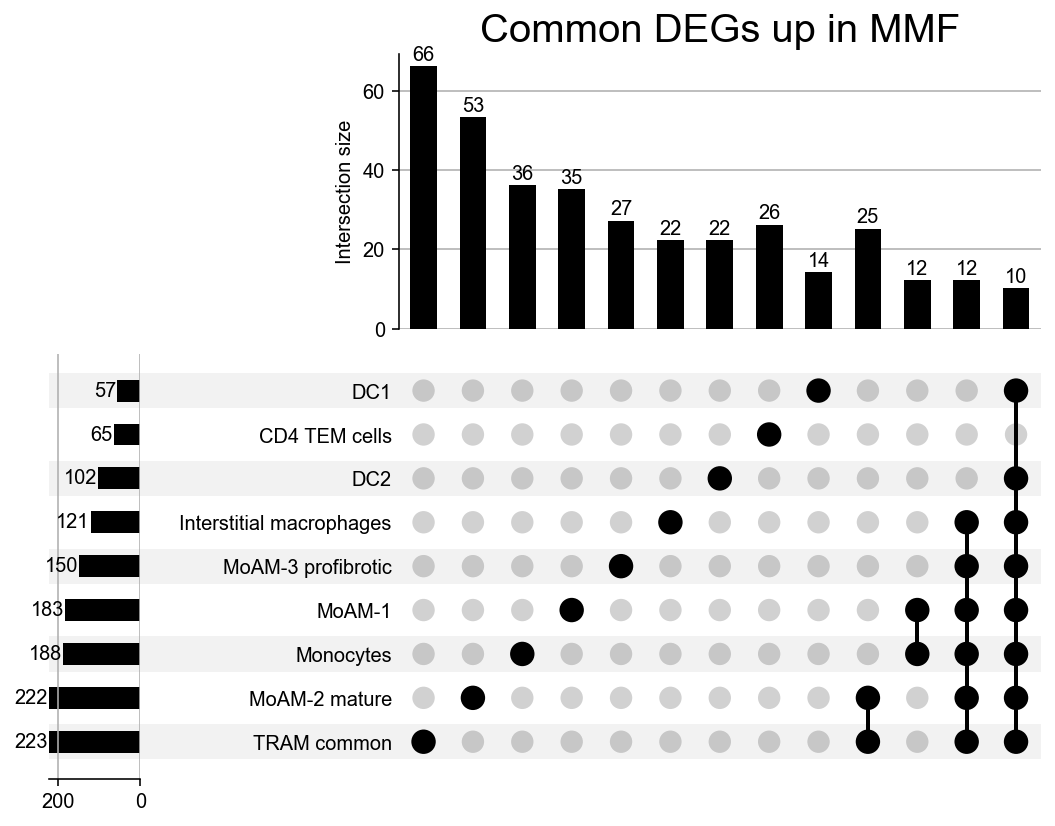

In [256]:
upset_plot_data = upsetplot.from_contents(common_degs['mmf'])
p = upsetplot.UpSet(
    upset_plot_data,
    show_counts=True,
    min_subset_size=10
).plot()
p['intersections'].set_title('Common DEGs up in MMF', size=20);

### Plot % unique DEGs per cell type

In [257]:
plot_df = []
for i, ct in enumerate(upset_plot_data.index.names):
    uniq_idx = [False] * len(upset_plot_data.index.names)
    uniq_idx[i] = True
    uniq_idx = tuple(uniq_idx)
    n_uniq = upset_plot_data.loc[uniq_idx].shape[0]
    n_total = np.sum(upset_plot_data.index.get_level_values(i))
    plot_df.append([ct, n_uniq, n_total])
plot_df = pd.DataFrame(plot_df, columns=['cell_type', 'n_uniq', 'n_total'])
plot_df['pct_uniq'] = plot_df.n_uniq / plot_df.n_total * 100

<ipython-input-257-046292912372>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  n_uniq = upset_plot_data.loc[uniq_idx].shape[0]


In [ ]:
CT_ORDER = [
    'Monocytes',
    'MoAM-1',
    'MoAM-2 mature',
    'MoAM-3 profibrotic',

    'TRAM common',

    'Interstitial macrophages',

    'CD4 TEM cells',

    'DC1',
    'DC2'
]
plot_df.cell_type = pd.Categorical(plot_df.cell_type, categories=CT_ORDER)

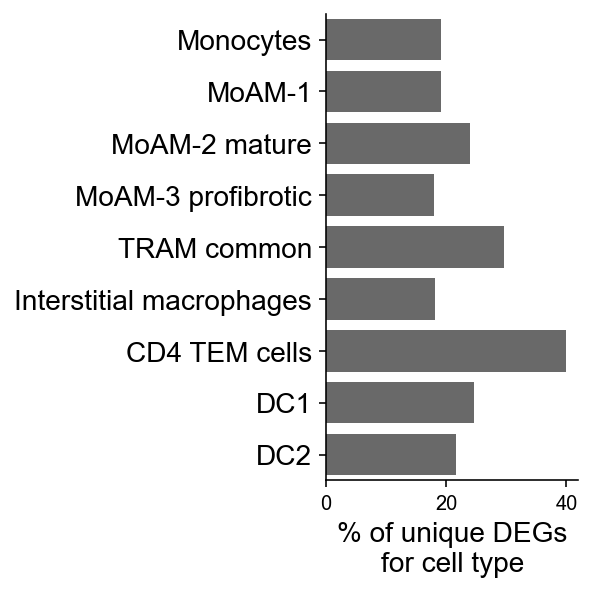

In [259]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
sns.barplot(
    data=plot_df,
    y='cell_type',
    x='pct_uniq',
    palette=['dimgray']
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('% of unique DEGs\nfor cell type', size=14)
ax.set_ylabel('')
ax.tick_params(axis='y', labelsize=14)
fig.savefig('00_figures/Figure_4B_pct_uniq_degs.pdf')

# 3. TRAM common DEGs and GOs in V3 chemistry

## 3.1 TRAM common DEGs

In [40]:
trams = list(filter(lambda x: x.startswith("TRAM"), data.keys()))

In [41]:
tram_degs = {'naive': {}, 'mmf': {}}
for ct in trams:
    degs = data[ct]['filtered_degs']
    tram_degs['naive'][ct] = degs.index[degs.sign.eq('Up in Naive')].tolist()
    tram_degs['mmf'][ct] = degs.index[degs.sign.eq('Up in MMF')].tolist()

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


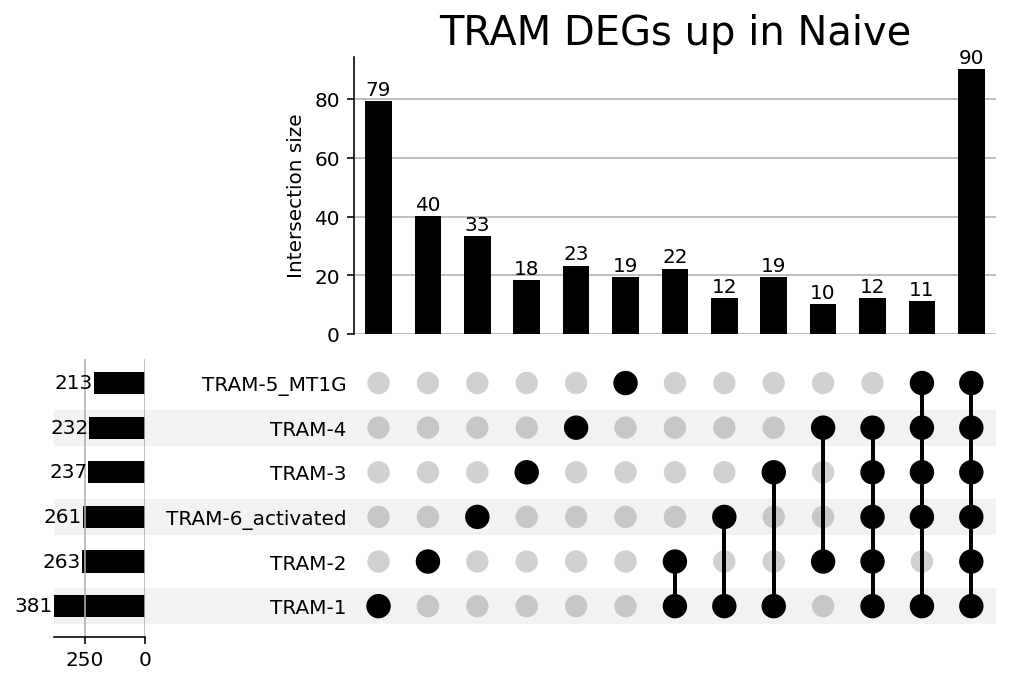

In [42]:
p = upsetplot.UpSet(
    upsetplot.from_contents(tram_degs['naive']),
    show_counts=True,
    min_subset_size=10
).plot()
p['intersections'].set_title('TRAM DEGs up in Naive', size=20);

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


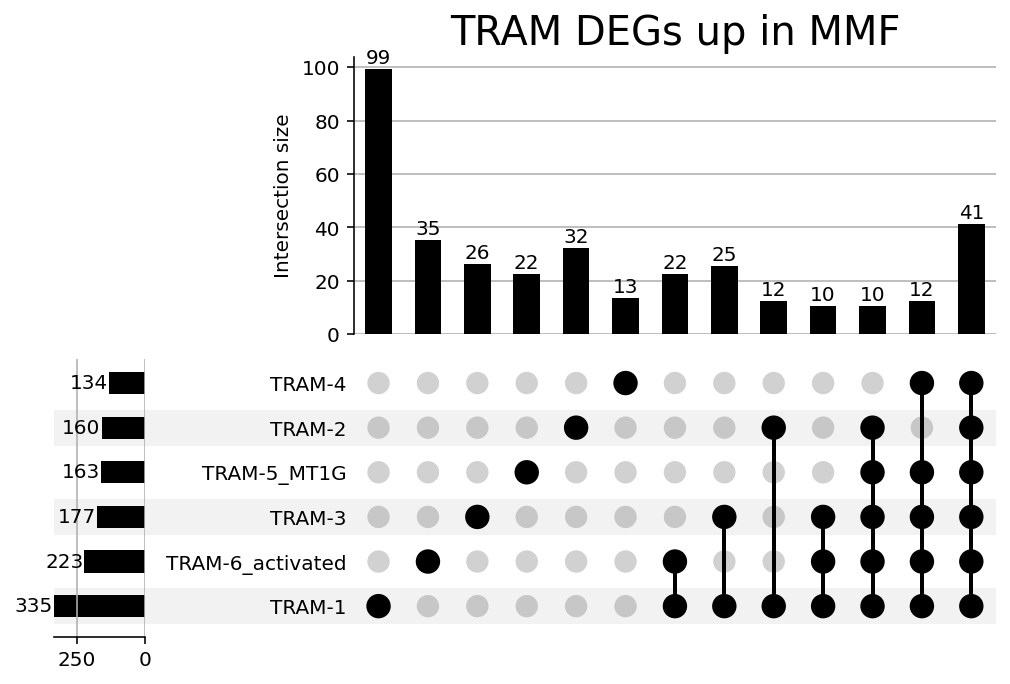

In [43]:
p = upsetplot.UpSet(
    upsetplot.from_contents(tram_degs['mmf']),
    show_counts=True,
    min_subset_size=10
).plot()
p['intersections'].set_title('TRAM DEGs up in MMF', size=20);

In [44]:
tram_common_naive_degs = collections.Counter()
tram_common_mmf_degs = collections.Counter()
for ct in trams:
    degs = data[ct]['filtered_degs']
    tram_common_naive_degs.update(degs.index[degs.sign.eq('Up in Naive')].tolist())
    tram_common_mmf_degs.update(degs.index[degs.sign.eq('Up in MMF')].tolist())

In [45]:
analysis_base = DEG_DIR / '__analysis'

In [46]:
os.makedirs(analysis_base, exist_ok=True)

In [47]:
all_tram_naive_degs = [g for g, c in tram_common_naive_degs.items() if c == 6]
with open(analysis_base / '01_tram_all_naive_degs.txt', 'w') as f:
    f.write('\n'.join(all_tram_naive_degs))

In [48]:
all_tram_mmf_degs = [g for g, c in tram_common_mmf_degs.items() if c == 6]
with open(analysis_base / '01_tram_all_mmf_degs.txt', 'w') as f:
    f.write('\n'.join(all_tram_mmf_degs))

## 3.2 TRAM common differentially-expressed TFs

In [49]:
tram_tfs = {'naive': {}, 'mmf': {}}
for ct in trams:
    degs = data[ct]['filtered_degs']
    tram_tfs['naive'][ct] = degs.index[degs.sign.eq('Up in Naive') & degs.index.isin(TFS)].tolist()
    tram_tfs['mmf'][ct] = degs.index[degs.sign.eq('Up in MMF') & degs.index.isin(TFS)].tolist()

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


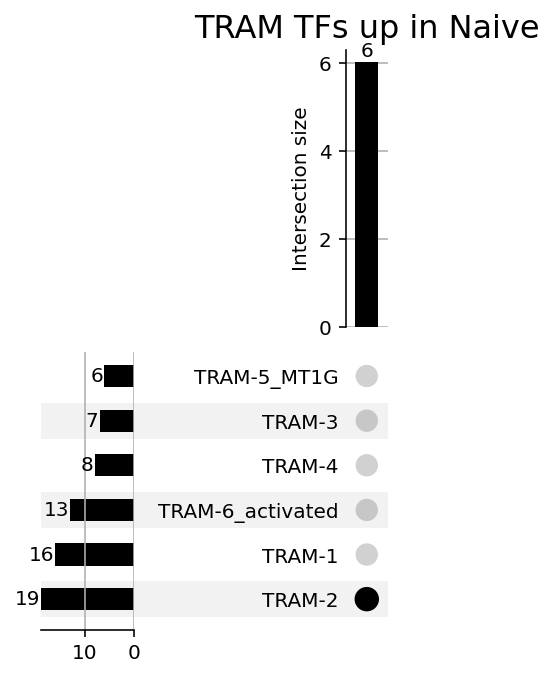

In [50]:
p = upsetplot.UpSet(
    upsetplot.from_contents(tram_tfs['naive']),
    show_counts=True,
    min_subset_size=5
).plot()
p["intersections"].set_title("TRAM TFs up in Naive", size=16);

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


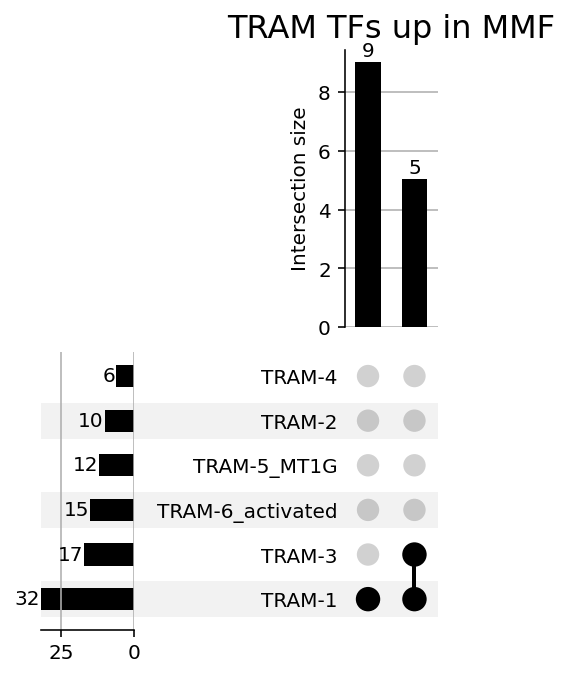

In [51]:
p = upsetplot.UpSet(
    upsetplot.from_contents(tram_tfs['mmf']),
    show_counts=True,
    min_subset_size=5
).plot()
p["intersections"].set_title("TRAM TFs up in MMF", size=16);

## 3.4 Which GO processes are enriched in common DEGs for TRAMs?

In [ ]:
go_upreg = run_go(
    all_tram_naive_degs,
    data["TRAM-1"]["filtered_degs"].index
)

**NOTE: DEFAULT TAXID STORED FROM gene2go IS 9606 (human)

HMS:0:01:10.261589 346,070 annotations, 20,758 genes, 18,733 GOs, 1 taxids READ: gene2go 

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact


**No GOs**

In [ ]:
go_downreg = run_go(
    all_tram_mmf_degs,
    data["TRAM-1"]["filtered_degs"].index
)

**NOTE: DEFAULT TAXID STORED FROM gene2go IS 9606 (human)

HMS:0:01:07.498578 346,070 annotations, 20,758 genes, 18,733 GOs, 1 taxids READ: gene2go 

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact


**No GOs**

In [54]:
sorted(all_tram_naive_degs)

['ACOT2',
 'AP1S2',
 'AP3S1',
 'APOBEC3C',
 'ARF6',
 'ARL6IP1',
 'ATP5I',
 'AXL',
 'B3GNT7',
 'B4GALT1',
 'BEST1',
 'C14orf2',
 'C1orf56',
 'C6orf48',
 'CAPZA1',
 'CBFB',
 'CCNL1',
 'CDC42SE1',
 'CDC42SE2',
 'CHMP4B',
 'CHP1',
 'CLK1',
 'CNOT7',
 'CRIP1',
 'CTBP1',
 'CTNNB1',
 'DAZAP2',
 'EGR2',
 'EI24',
 'FAM96A',
 'FBXO25',
 'FKBP1A',
 'GABARAP',
 'GPR65',
 'HMGN2',
 'HNRNPA1',
 'HNRNPH1',
 'IER3IP1',
 'LPXN',
 'LSM5',
 'LST1',
 'LY96',
 'MIF',
 'MMP14',
 'MTHFD2',
 'NDUFA11',
 'NDUFA13',
 'NDUFA3',
 'NDUFA7',
 'NDUFB1',
 'PET100',
 'POLD4',
 'POLR2L',
 'PPP1CB',
 'PRR13',
 'PSMA2',
 'PSMD9',
 'PTPRO',
 'RASSF3',
 'RHBDD2',
 'RHOB',
 'RIN2',
 'RNF145',
 'ROMO1',
 'SCGB1A1',
 'SCGB3A1',
 'SLIRP',
 'SNRNP27',
 'SPG21',
 'SRSF2',
 'SRSF6',
 'SRSF8',
 'ST3GAL6',
 'STARD7',
 'TAX1BP3',
 'TMA7',
 'TMED2',
 'TMEM230',
 'TMEM33',
 'TMSB10',
 'TMSB4X',
 'TRA2A',
 'TRA2B',
 'TSPYL1',
 'UBE2E2',
 'UQCR11',
 'UQCRQ',
 'USMG5',
 'WTAP',
 'YAF2']

# 4. Heatmaps

We take pseudobulk as average $log(\text{10k-norm} + 1)$ gene counts per sample per cell type, and plot the DEGs in a heatmap

## 4.1 All DEGs from all cell types

1. Collect all DEGs

In [55]:
all_degs = []
for ct, info in data.items():
    degs = info['filtered_degs']
    all_degs.append(degs.index[degs.sign.notna()].tolist())
all_degs = functools.reduce(np.union1d, all_degs)

In [56]:
all_degs.size

1590

2. Take pseudobulks

In [57]:
ds_processed.obs['mmf'] = CLINICAL.set_index('study_code').patient_on_mmf.map(
    {True: 'MMF', False: 'Naive'}
)[
    ds_processed.obs.Sample.str.replace('_followup', '').values
].values

In [58]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.Status.eq("SSc")
][
    ['External Sample ID', 'cell_type', 'mmf']
].drop_duplicates(subset=['External Sample ID', 'cell_type'])

In [59]:
pseudobulk = np.zeros((metadata_df.shape[0], all_degs.size))
gene_idx = ds_processed.raw.var_names.isin(all_degs)
gene_names = ds_processed.raw.var_names[gene_idx]
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.eq(metadata_row.cell_type)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx][:, gene_idx].mean(axis=0)

In [60]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=gene_names)

In [61]:
metadata_df.mmf = pd.Categorical(metadata_df.mmf, categories=['Naive', 'MMF'])

Z-score pseudobulk

In [62]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [63]:
col_colors_df = get_color_annotations(metadata_df, {
    'cell_type': sc.plotting.palettes.default_28,
    'mmf': [(0.3, 0.4, 0.9), (0.9, 0.3, 0.3)],
    'External Sample ID': 'tab20'
})

In [64]:
sample_order = metadata_df.sort_values(
    ['mmf', 'cell_type', 'External Sample ID']
).index

In [65]:
legend_handles = {}
for l in ('cell_type',):
    legend_handles[l] = []
    labels = metadata_df[[l]].drop_duplicates().sort_values(l)
    colors = col_colors_df.loc[labels.index, l]
    for label, color in zip(labels[l], colors):
        legend_handles[l].append(mpl.patches.Patch(
            label=label,
            color=color
        ))

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.draw()
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(**tight_params)


Text(0.5, 1.0, 'Pseudobulk expression of 1590 DEGs for all cell types')

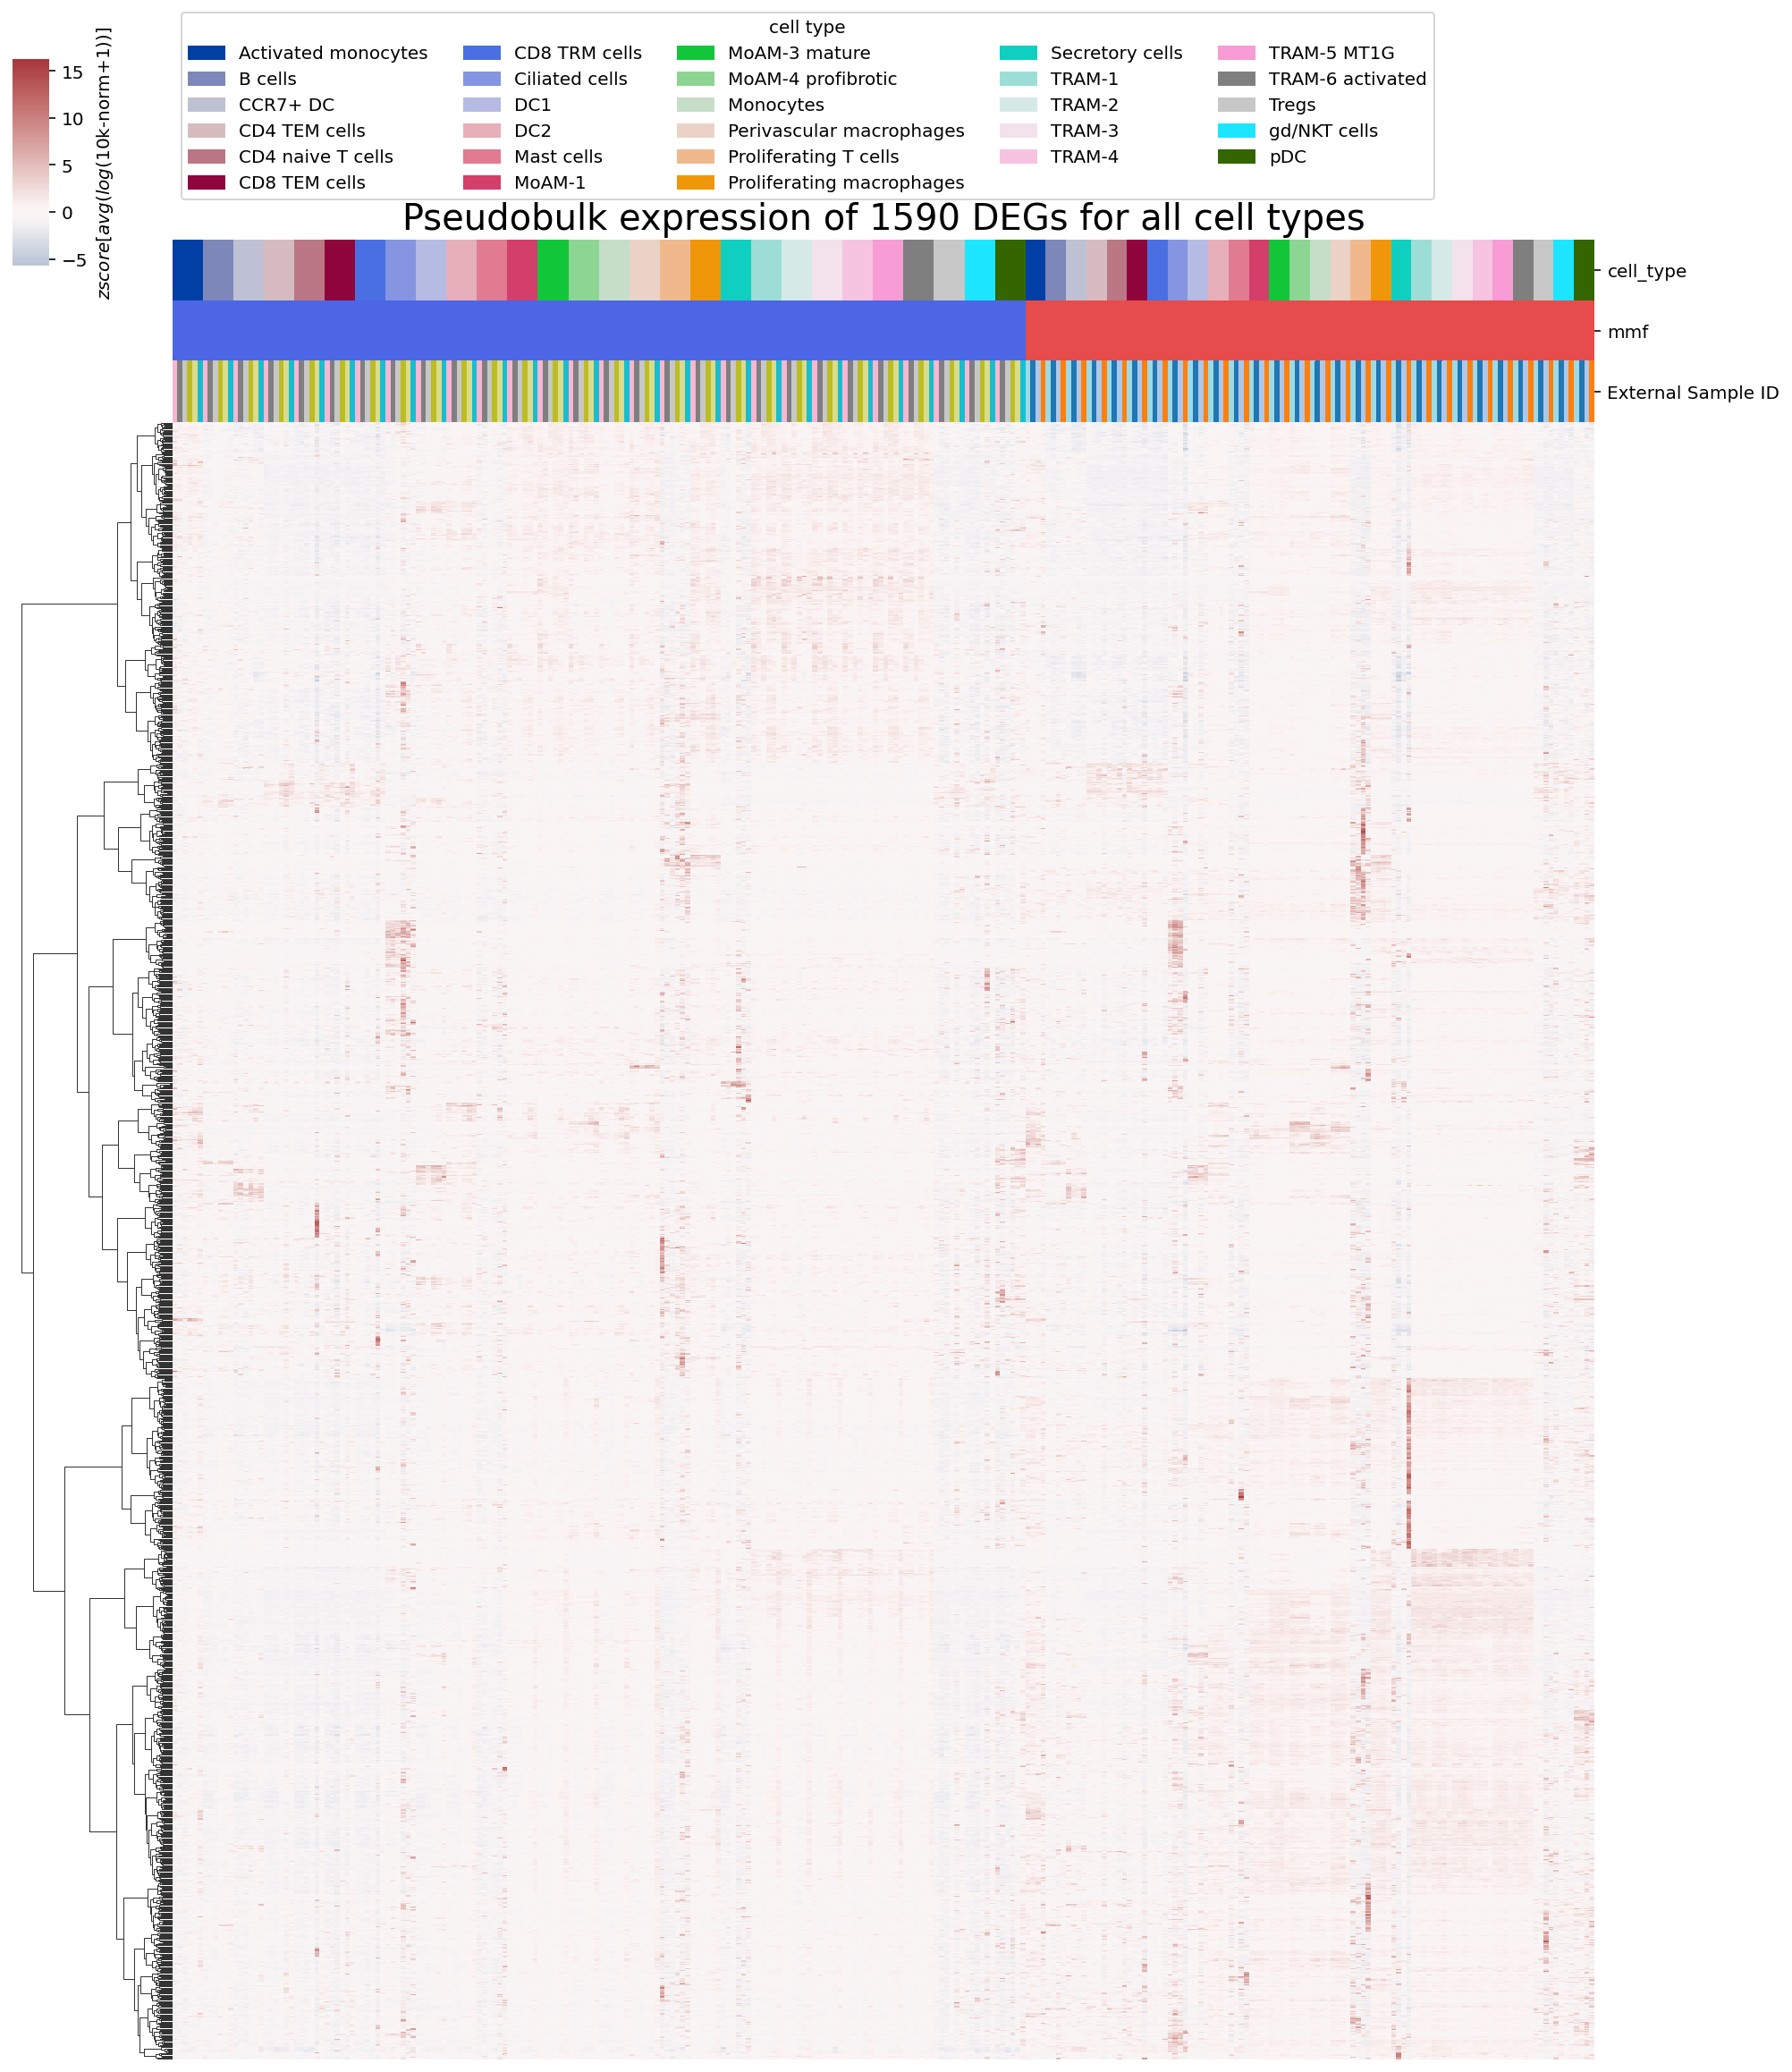

In [ ]:
cg = sns.clustermap(
    pseudobulk.loc[sample_order].T,
    figsize=(14, 16),
    method='ward',
    col_cluster=False,
    col_colors=col_colors_df.loc[sample_order],
    yticklabels=[],
    xticklabels=[],
    cmap='vlag',
    center=0,
    cbar_kws={'label': '$zscore[avg(log($10k-norm$ + 1))]$'},
    cbar_pos=(0.01, 0.88, 0.02, 0.1),
    dendrogram_ratio=0.1
)
cg.ax_col_colors.tick_params(left=False, labelleft=False, right=True, labelright=True)
cg.ax_col_colors.legend(
    handles=legend_handles['cell_type'],
    title='cell type',
    ncol=5,
    loc='upper left',
    bbox_to_anchor=(0, 2.3)
)
cg.ax_col_colors.set_title(
    f'Pseudobulk expression of {all_degs.size} DEGs for all cell types',
    size=20
)

Text(0.5, 1.0, 'Pseudobulk expression of 1590 DEGs for all cell types')

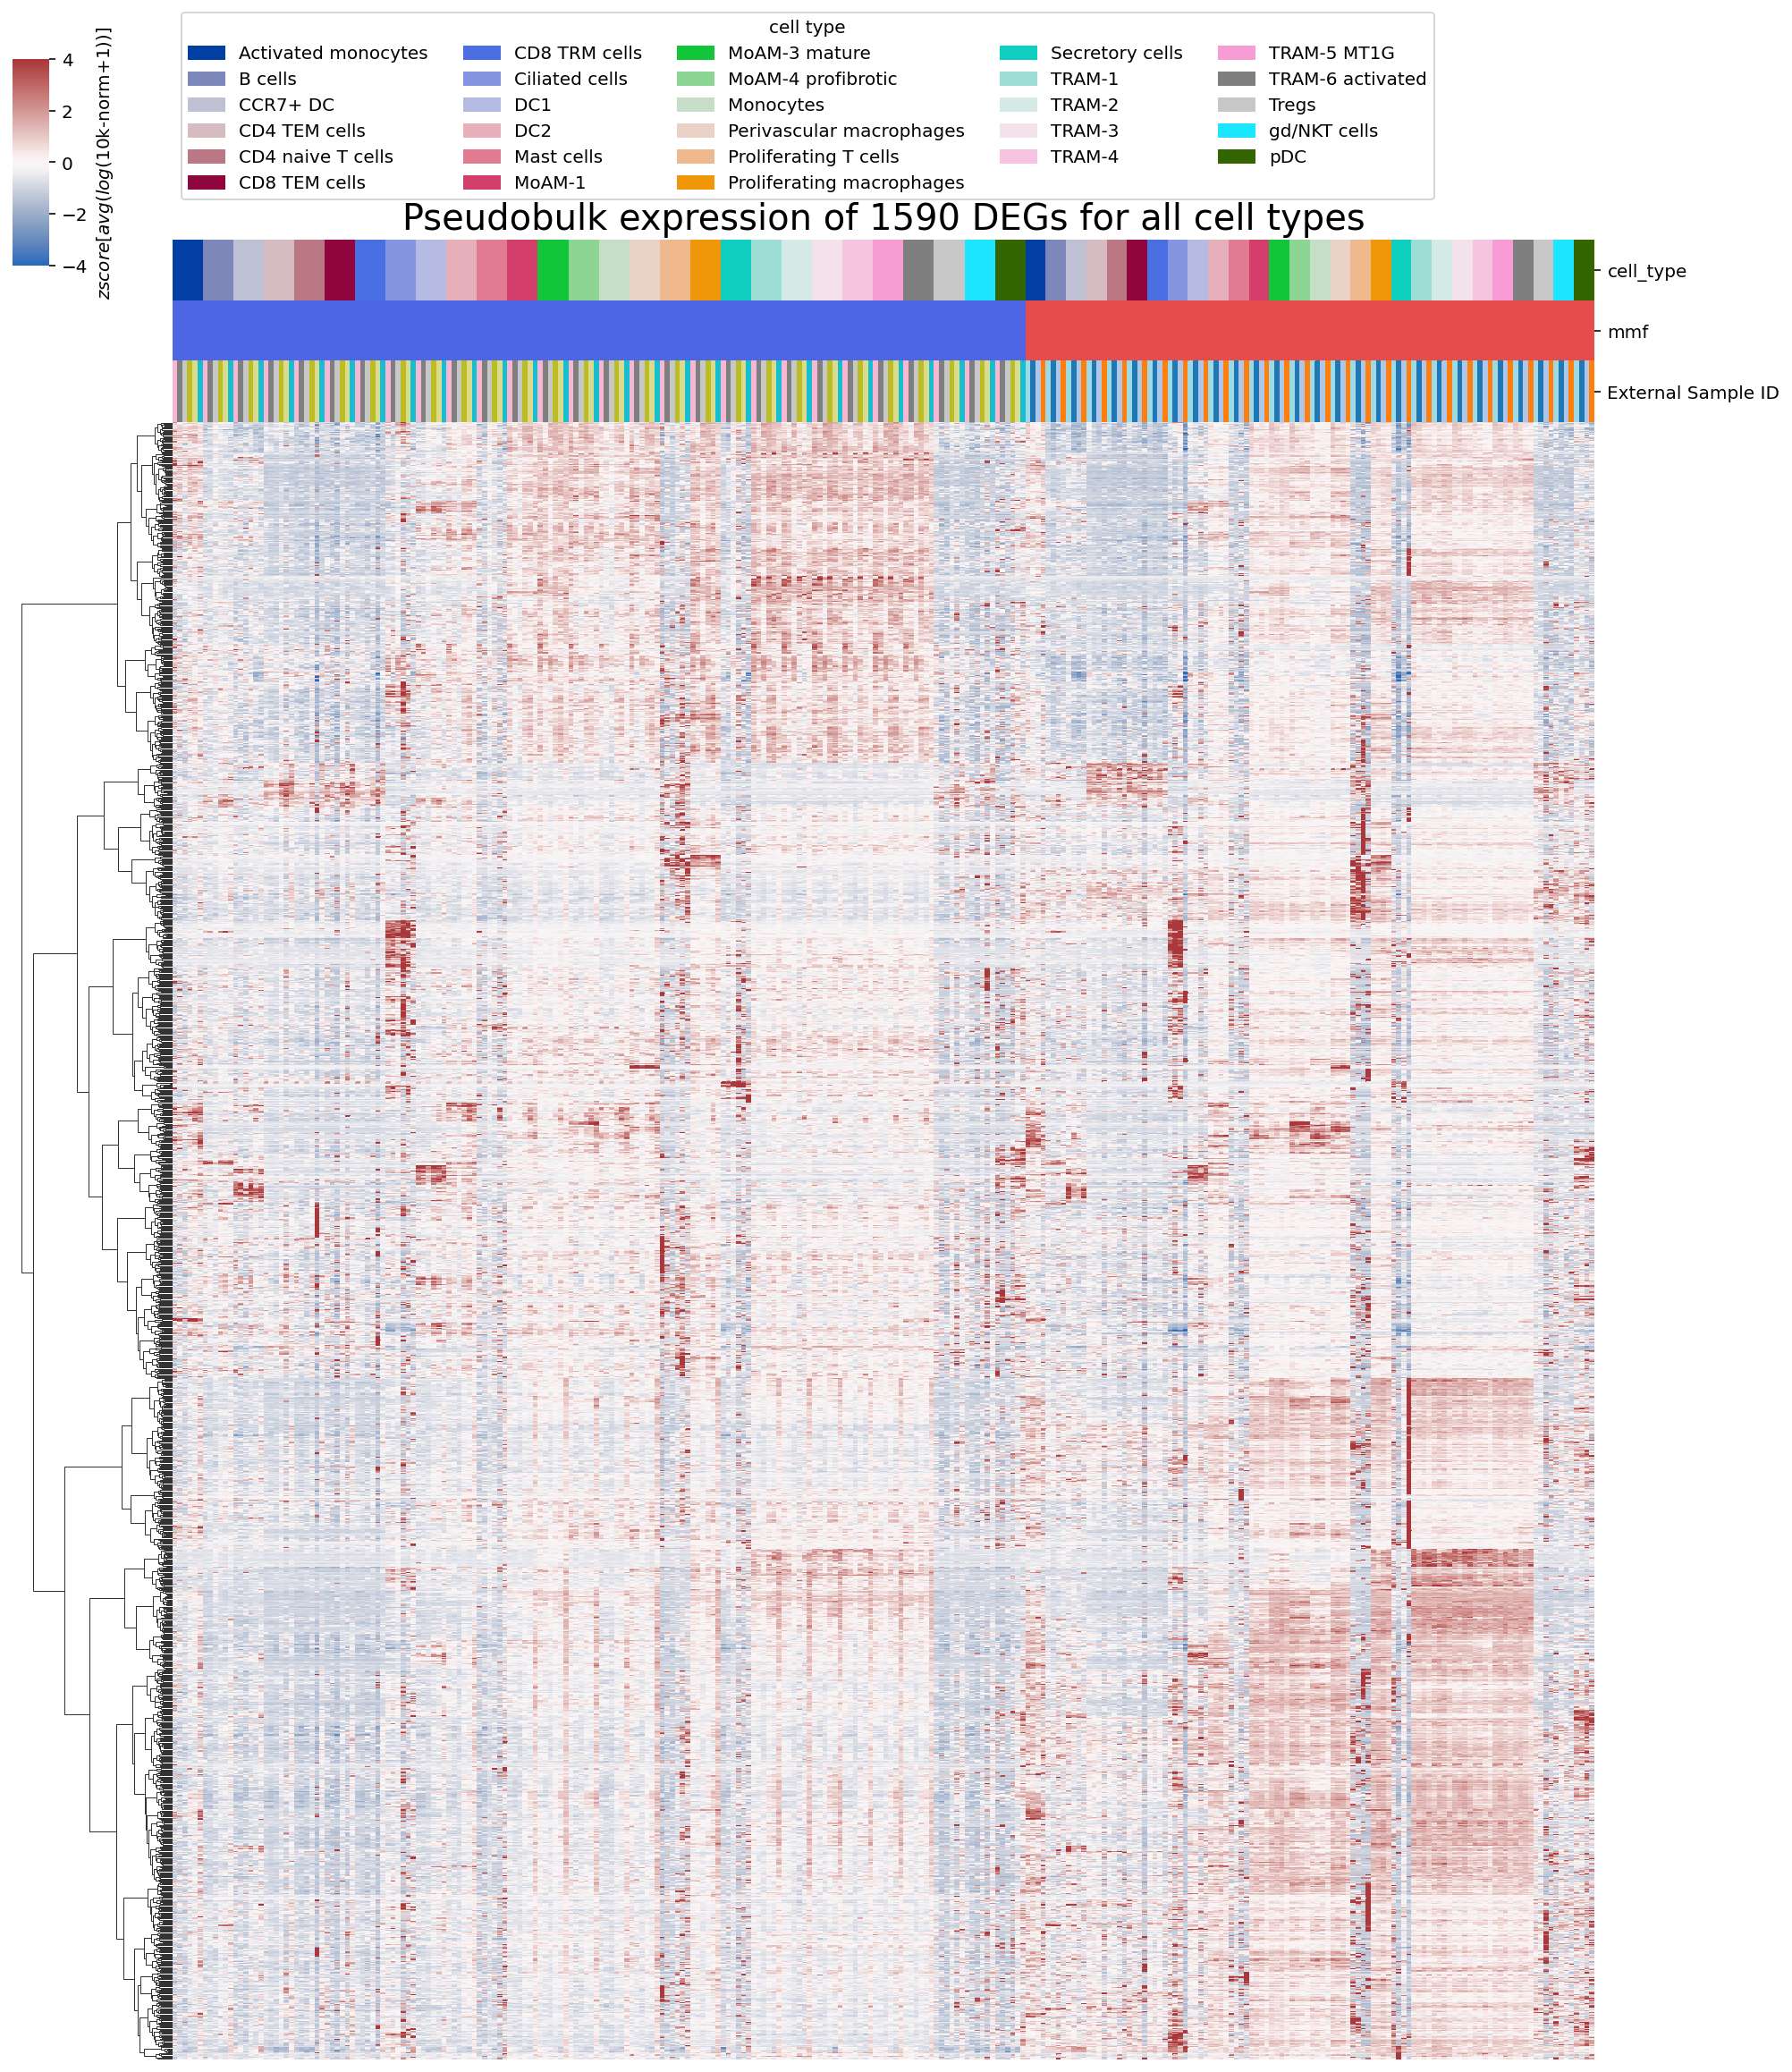

In [ ]:
cg = sns.clustermap(
    pseudobulk.loc[sample_order].T,
    figsize=(14, 16),
    method='ward',
    col_cluster=False,
    col_colors=col_colors_df.loc[sample_order],
    yticklabels=[],
    xticklabels=[],
    cmap='vlag',
    center=0,
    vmin=-4,
    vmax=4,
    cbar_kws={'label': '$zscore[avg(log($10k-norm$ + 1))]$'},
    cbar_pos=(0.01, 0.88, 0.02, 0.1),
    dendrogram_ratio=0.1
)
cg.ax_col_colors.tick_params(left=False, labelleft=False, right=True, labelright=True)
cg.ax_col_colors.legend(
    handles=legend_handles['cell_type'],
    title='cell type',
    ncol=5,
    loc='upper left',
    bbox_to_anchor=(0, 2.3)
)
cg.ax_col_colors.set_title(
    f'Pseudobulk expression of {all_degs.size} DEGs for all cell types',
    size=20
)

In [68]:
rows = []
for k, v in data.items():
    degs = v["filtered_degs"]
    n_degs = degs.sign.notna().sum()
    rows.append((k, n_degs))
df = pd.DataFrame(rows, columns=["name", "n_degs"])

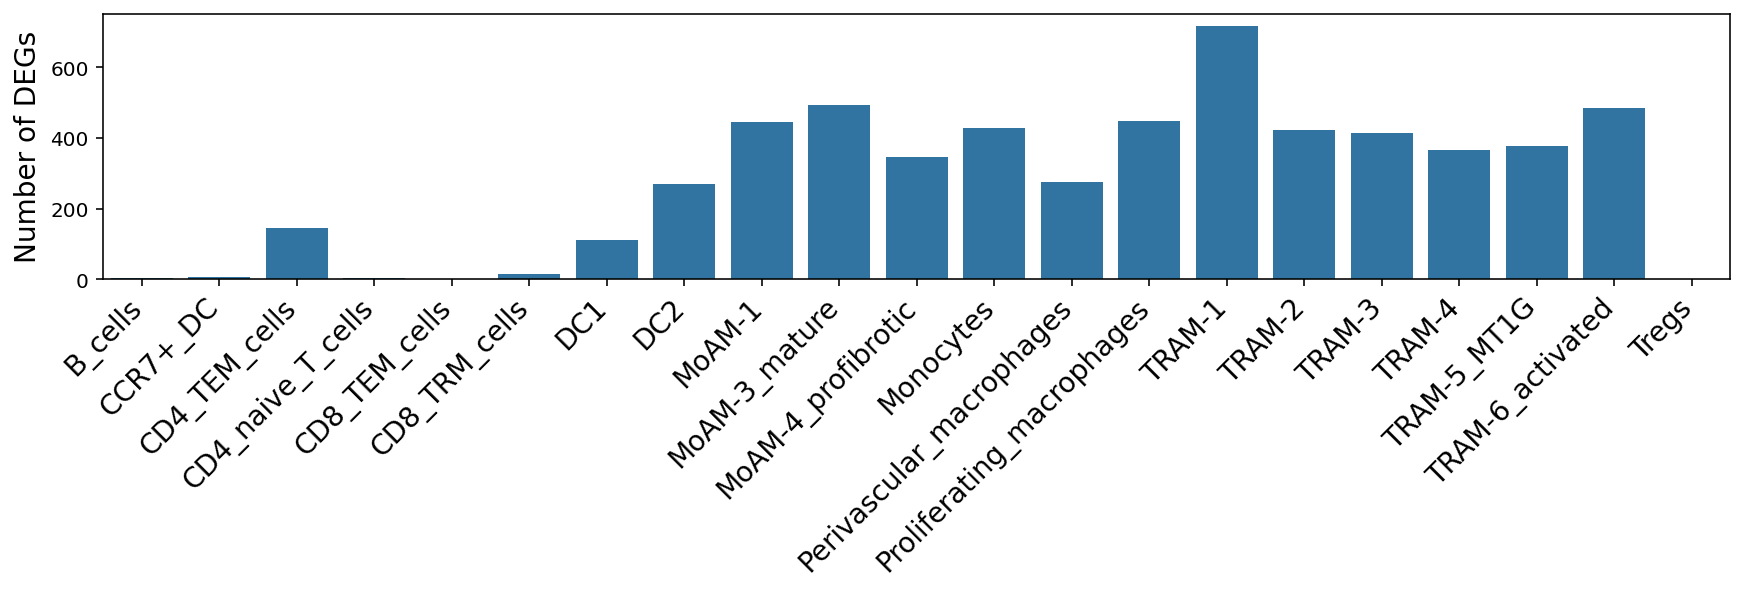

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(
    data=df.sort_values('name'),
    y="n_degs",
    x="name",
    ax=ax,
    palette=['tab:blue']
)
ax.set_xticklabels(
    df.sort_values('name').name,
    rotation=45,
    ha="right",
    fontsize=14
)
ax.set_ylabel("Number of DEGs", fontsize=14)
ax.set_xlabel("")
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

Based on the above, let's plot the heatmap for certain cell types only

## 4.2 All DEGs from selected cell types

In [70]:
deg_cell_types = [
    'MoAM-3 mature', 'Proliferating macrophages', 'TRAM-1',
    'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5 MT1G', 'TRAM-6 activated'
]

In [71]:
ct_slugs = [i.replace(' ', '_').replace('*', '').replace(';', '_and') for i in deg_cell_types]

1. Collect all DEGs

In [72]:
all_degs = []
for ct, info in data.items():
    if ct not in ct_slugs:
        continue
    degs = info['filtered_degs']
    all_degs.append(degs.index[degs.sign.notna()].tolist())
all_degs = functools.reduce(np.union1d, all_degs)

In [73]:
all_degs.size

1201

2. Take pseudobulks

In [74]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.Status.eq("SSc")
    & ds_processed.obs.cell_type.isin(deg_cell_types)
][
    ['External Sample ID', 'cell_type', 'mmf']
].drop_duplicates(subset=['External Sample ID', 'cell_type'])

In [75]:
pseudobulk = np.zeros((metadata_df.shape[0], all_degs.size))
gene_idx = ds_processed.raw.var_names.isin(all_degs)
gene_names = ds_processed.raw.var_names[gene_idx]
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.eq(metadata_row.cell_type)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx][:, gene_idx].mean(axis=0)

In [76]:
pseudobulk.shape

(80, 1201)

In [77]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=gene_names)

Z-score pseudobulk

In [78]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [79]:
metadata_df.mmf = pd.Categorical(metadata_df.mmf, categories=['Naive', 'MMF'])

In [80]:
metadata_df.cell_type = metadata_df.cell_type.astype(str)

In [81]:
col_colors_df = get_color_annotations(metadata_df, {
    'cell_type': 'Dark2',
    'mmf': [(0.3, 0.4, 0.9), (0.9, 0.3, 0.3)],
    'External Sample ID': 'tab20'
})

In [82]:
sample_order = metadata_df.sort_values(
    ['mmf', 'cell_type', 'External Sample ID']
).index

In [83]:
legend_handles = {}
for l in ('cell_type',):
    legend_handles[l] = []
    labels = metadata_df[[l]].drop_duplicates().sort_values(l)
    colors = col_colors_df.loc[labels.index, l]
    for label, color in zip(labels[l], colors):
        legend_handles[l].append(mpl.patches.Patch(
            label=label,
            color=color
        ))

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.draw()
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(**tight_params)


Text(0.5, 1.0, 'Pseudobulk expression of 1201 DEGs for selected cell types\nordered by Naive/MMF')

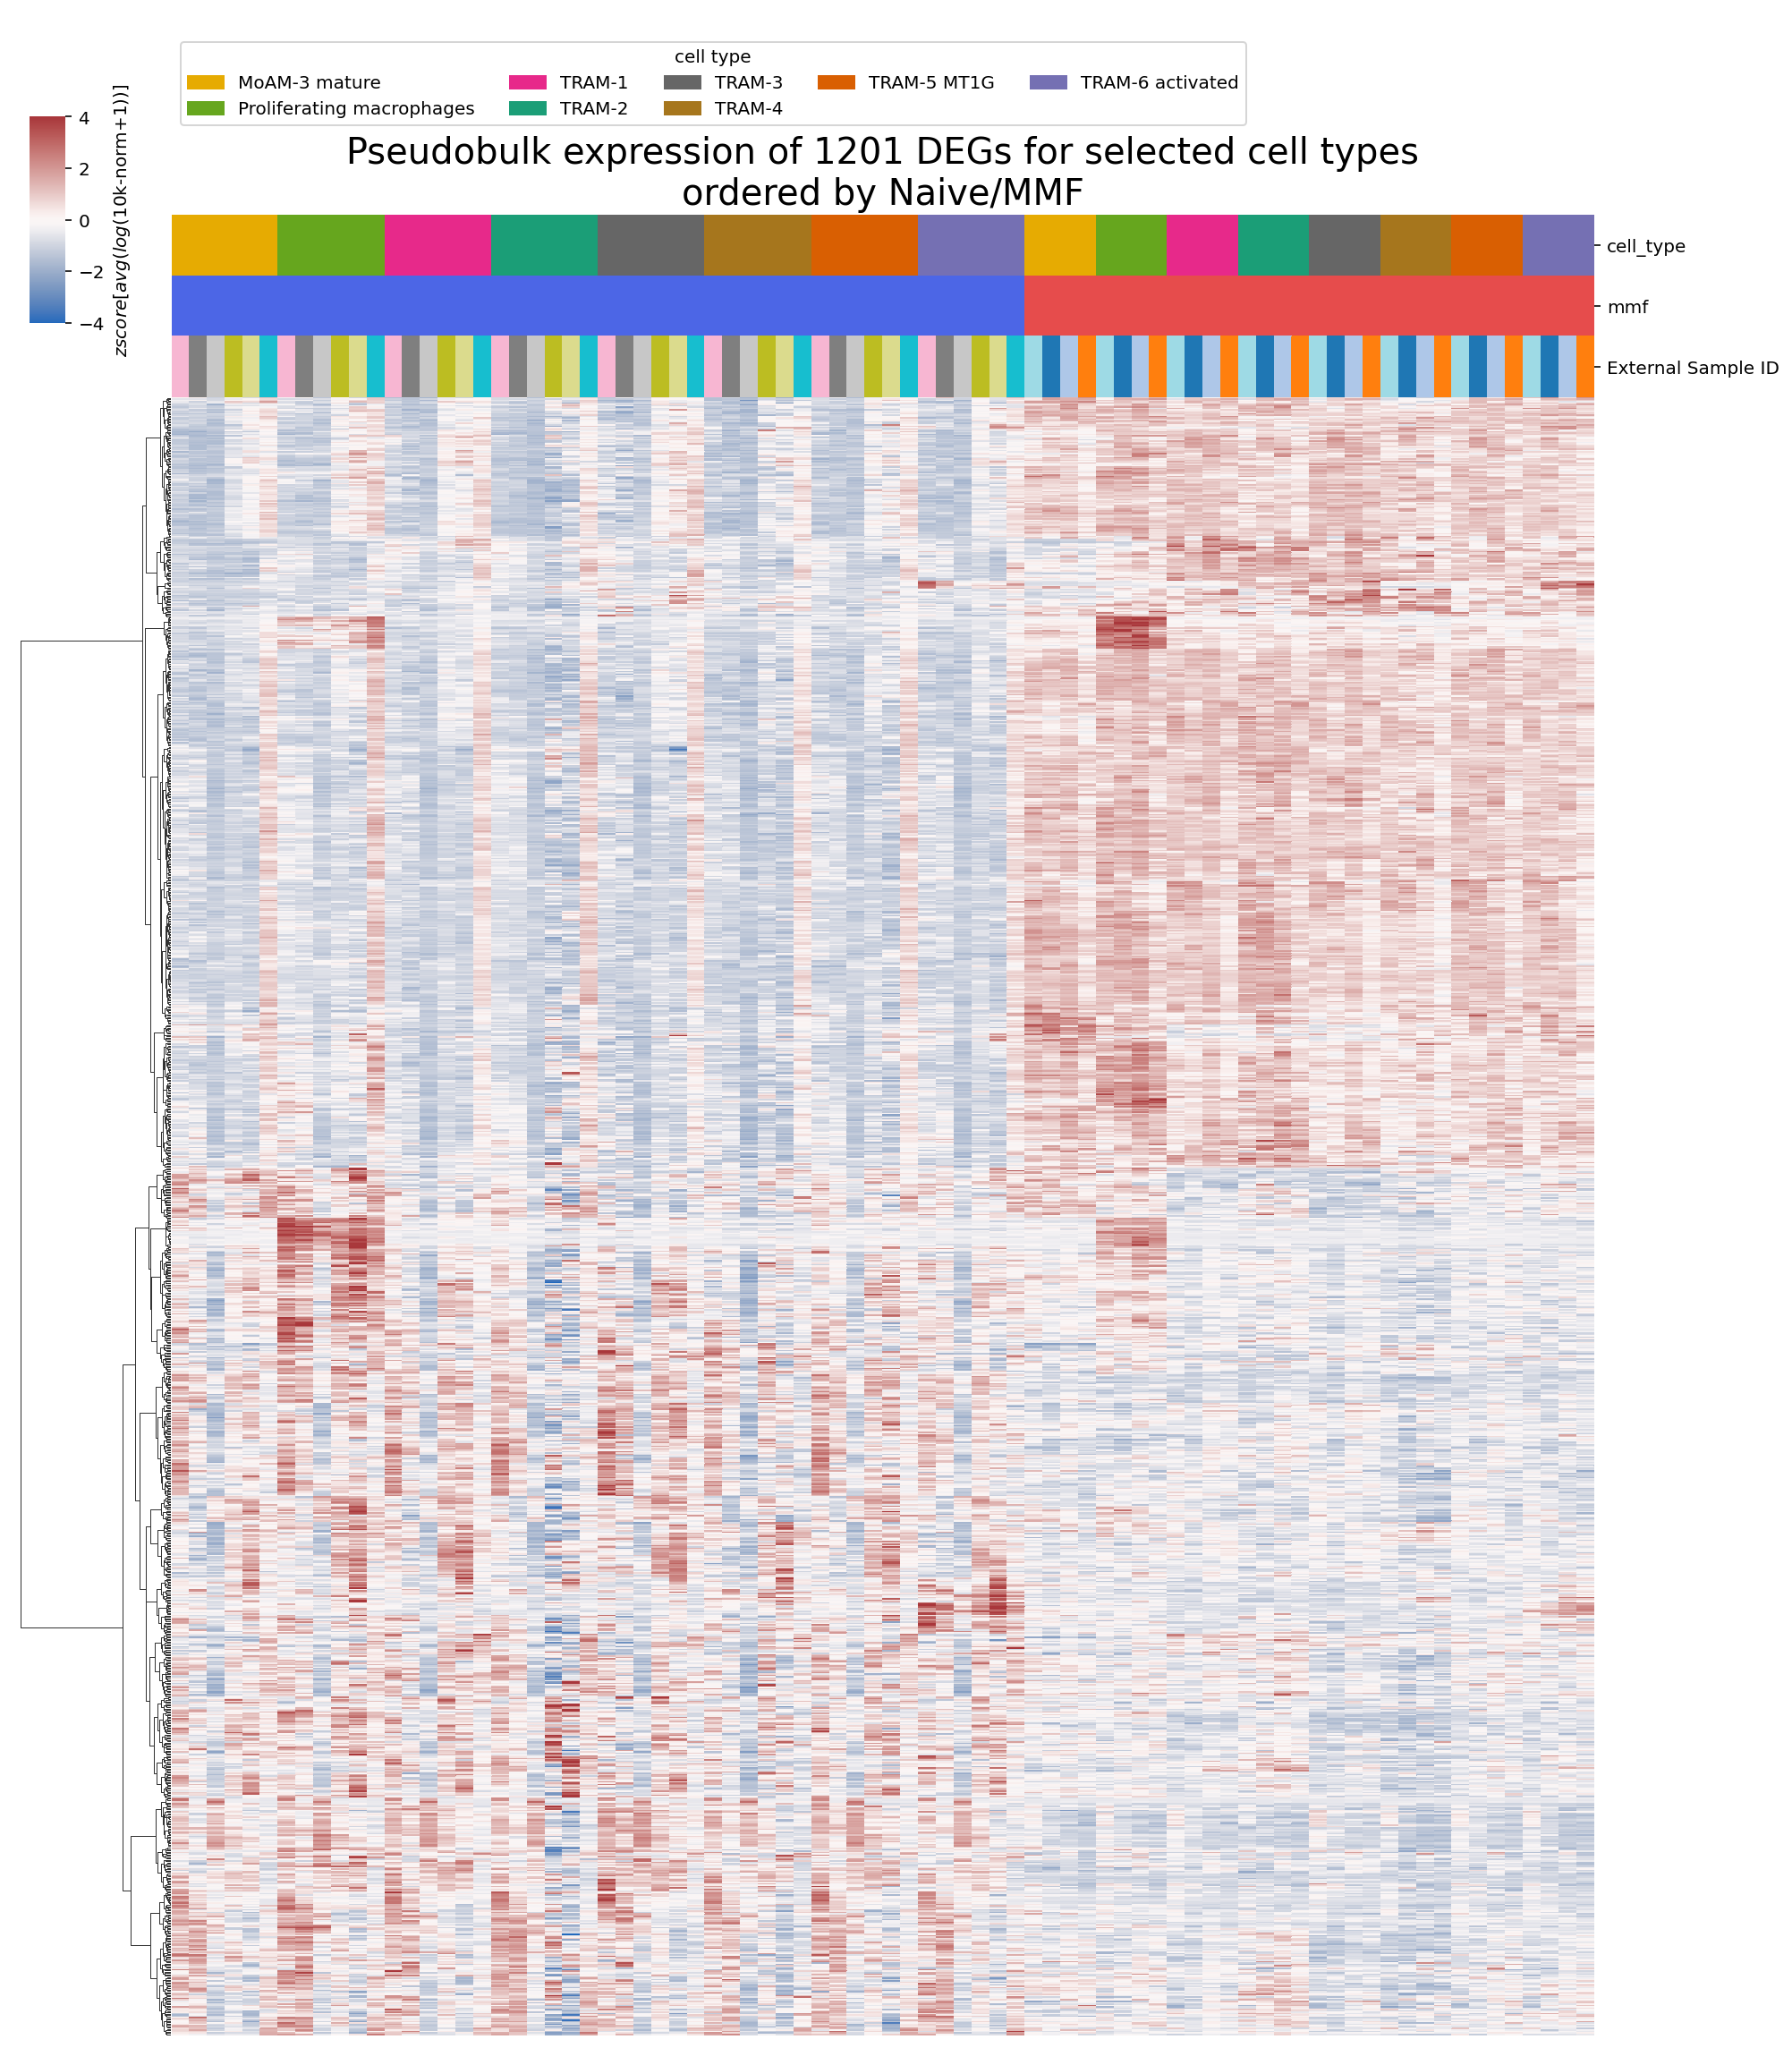

In [ ]:
cg = sns.clustermap(
    pseudobulk.loc[sample_order].T,
    figsize=(14, 16),
    method='ward',
    col_cluster=False,
    col_colors=col_colors_df.loc[sample_order],
    yticklabels=[],
    xticklabels=[],
    cmap='vlag',
    center=0,
    vmin=-4,
    vmax=4,
    cbar_kws={'label': '$zscore[avg(log($10k-norm$ + 1))]$'},
    cbar_pos=(0.02, 0.84, 0.02, 0.1),
    dendrogram_ratio=0.1,
)
cg.ax_col_colors.tick_params(left=False, labelleft=False, right=True, labelright=True)
cg.ax_col_colors.legend(
    handles=legend_handles['cell_type'],
    title='cell type',
    ncol=5,
    loc='upper left',
    bbox_to_anchor=(0, 2)
)
cg.ax_col_colors.set_title(
    f'Pseudobulk expression of {all_degs.size} DEGs for selected cell types\n'
    'ordered by Naive/MMF',
    size=20
)

In [85]:
all_degs_data = []
for ct, info in data.items():
    if ct not in ct_slugs:
        continue
    degs = info['filtered_degs']
    all_degs_data.append(degs.loc[degs.sign.notna()])
all_degs_data = pd.concat(all_degs_data, axis=0)

In [86]:
all_degs_data['lfc_abs'] = all_degs_data.log2FoldChange.abs()

In [87]:
all_degs_data = all_degs_data.sort_values('lfc_abs', ascending=False).reset_index().rename(
    columns={'index': 'gene'}
).groupby('gene').head(1)

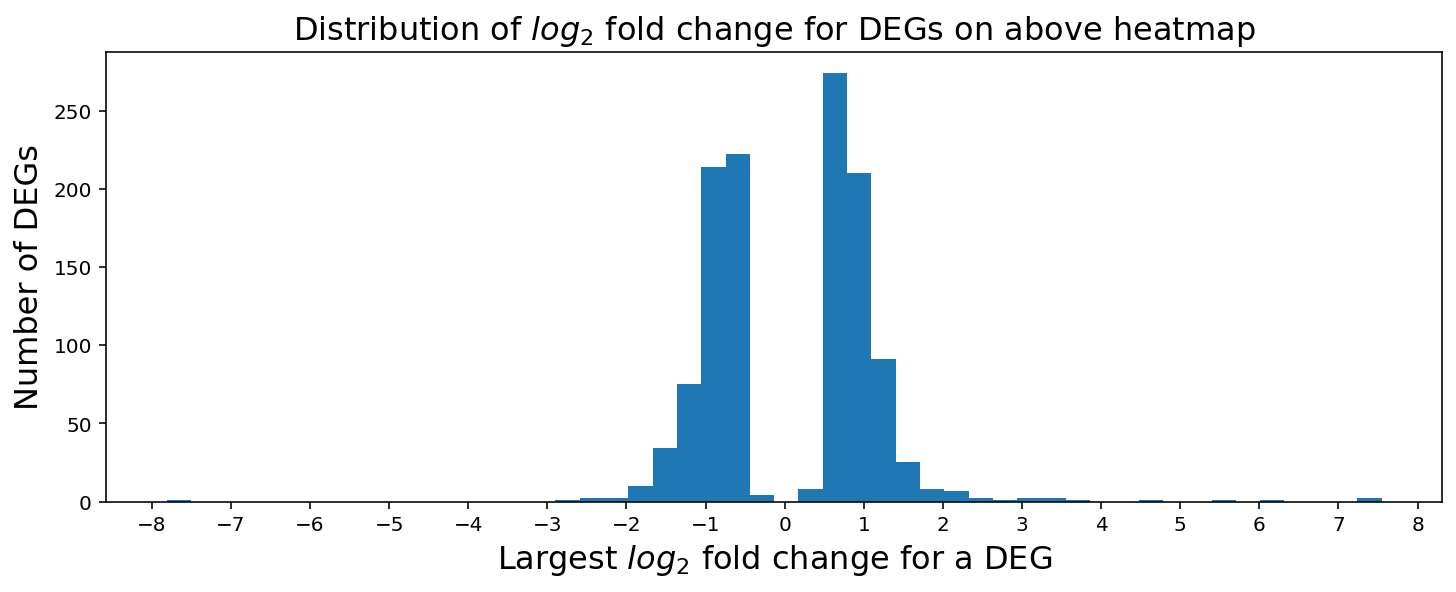

In [88]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(all_degs_data.log2FoldChange, bins=50)
ax.set_xlabel('Largest $log_2$ fold change for a DEG', size=16)
ax.set_ylabel('Number of DEGs', size=16)
ax.set_title('Distribution of $log_2$ fold change for DEGs on above heatmap', size=16)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

## 4.4 DEGs from selected cell types with $|log_2FC| > 0.7$

Based on above histogram of $log_2$ fold changes, let's take only DEGs with at least $0.7$ $log_2$ fold change.

1. Collect all DEGs

In [89]:
all_degs = []
all_degs_data = []
for ct, info in data.items():
    if ct not in ct_slugs:
        continue
    degs = info['filtered_degs']
    degs_slice = degs.loc[degs.sign.notna() & degs.log2FoldChange.abs().gt(0.7)]
    degs_names = degs_slice.index.tolist()
    all_degs.append(degs_names)
    all_degs_data.append(degs_slice)
all_degs_data = pd.concat(all_degs_data, axis=0)
all_degs = functools.reduce(np.union1d, all_degs)

In [90]:
all_degs.size

846

In [91]:
all_degs_data['lfc_abs'] = all_degs_data.log2FoldChange.abs()

In [92]:
all_degs_data = all_degs_data.sort_values('lfc_abs', ascending=False).reset_index().rename(
    columns={'index': 'gene'}
).groupby('gene').head(1)

In [93]:
all_degs_data.shape

(846, 9)

2. Take pseudobulks

In [94]:
metadata_df = ds_processed.obs.loc[
    ds_processed.obs.Status.eq("SSc")
    & ds_processed.obs.cell_type.isin(deg_cell_types)
][
    ['External Sample ID', 'cell_type', 'mmf']
].drop_duplicates(subset=['External Sample ID', 'cell_type'])

In [95]:
pseudobulk = np.zeros((metadata_df.shape[0], all_degs.size))
gene_idx = ds_processed.raw.var_names.isin(all_degs)
gene_names = ds_processed.raw.var_names[gene_idx]
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        ds_processed.obs.cell_type.eq(metadata_row.cell_type)
        & ds_processed.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = ds_processed.raw.X[metadata_idx][:, gene_idx].mean(axis=0)

In [96]:
pseudobulk.shape

(80, 846)

In [97]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=gene_names)

Z-score pseudobulk

In [98]:
pseudobulk = ((pseudobulk - pseudobulk.mean(axis=0)) / pseudobulk.std(axis=0))

In [99]:
metadata_df.mmf = pd.Categorical(metadata_df.mmf, categories=['Naive', 'MMF'])

In [100]:
metadata_df.cell_type = metadata_df.cell_type.astype(str)

In [101]:
col_colors_df = get_color_annotations(metadata_df, {
    'cell_type': 'Dark2',
    'mmf': [(0.3, 0.4, 0.9), (0.9, 0.3, 0.3)],
    'External Sample ID': 'tab20'
})

In [102]:
sample_order = metadata_df.sort_values(
    ['mmf', 'cell_type', 'External Sample ID']
).index

In [103]:
legend_handles = {}
for l in ('cell_type',):
    legend_handles[l] = []
    labels = metadata_df[[l]].drop_duplicates().sort_values(l)
    colors = col_colors_df.loc[labels.index, l]
    for label, color in zip(labels[l], colors):
        legend_handles[l].append(mpl.patches.Patch(
            label=label,
            color=color
        ))

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/utils.py:95: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.draw()
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(**tight_params)


Text(0.5, 1.0, 'Pseudobulk expression of 846 DEGs for selected cell types\nwith $log_2FC > 0.7$, ordered by Naive/MMF')

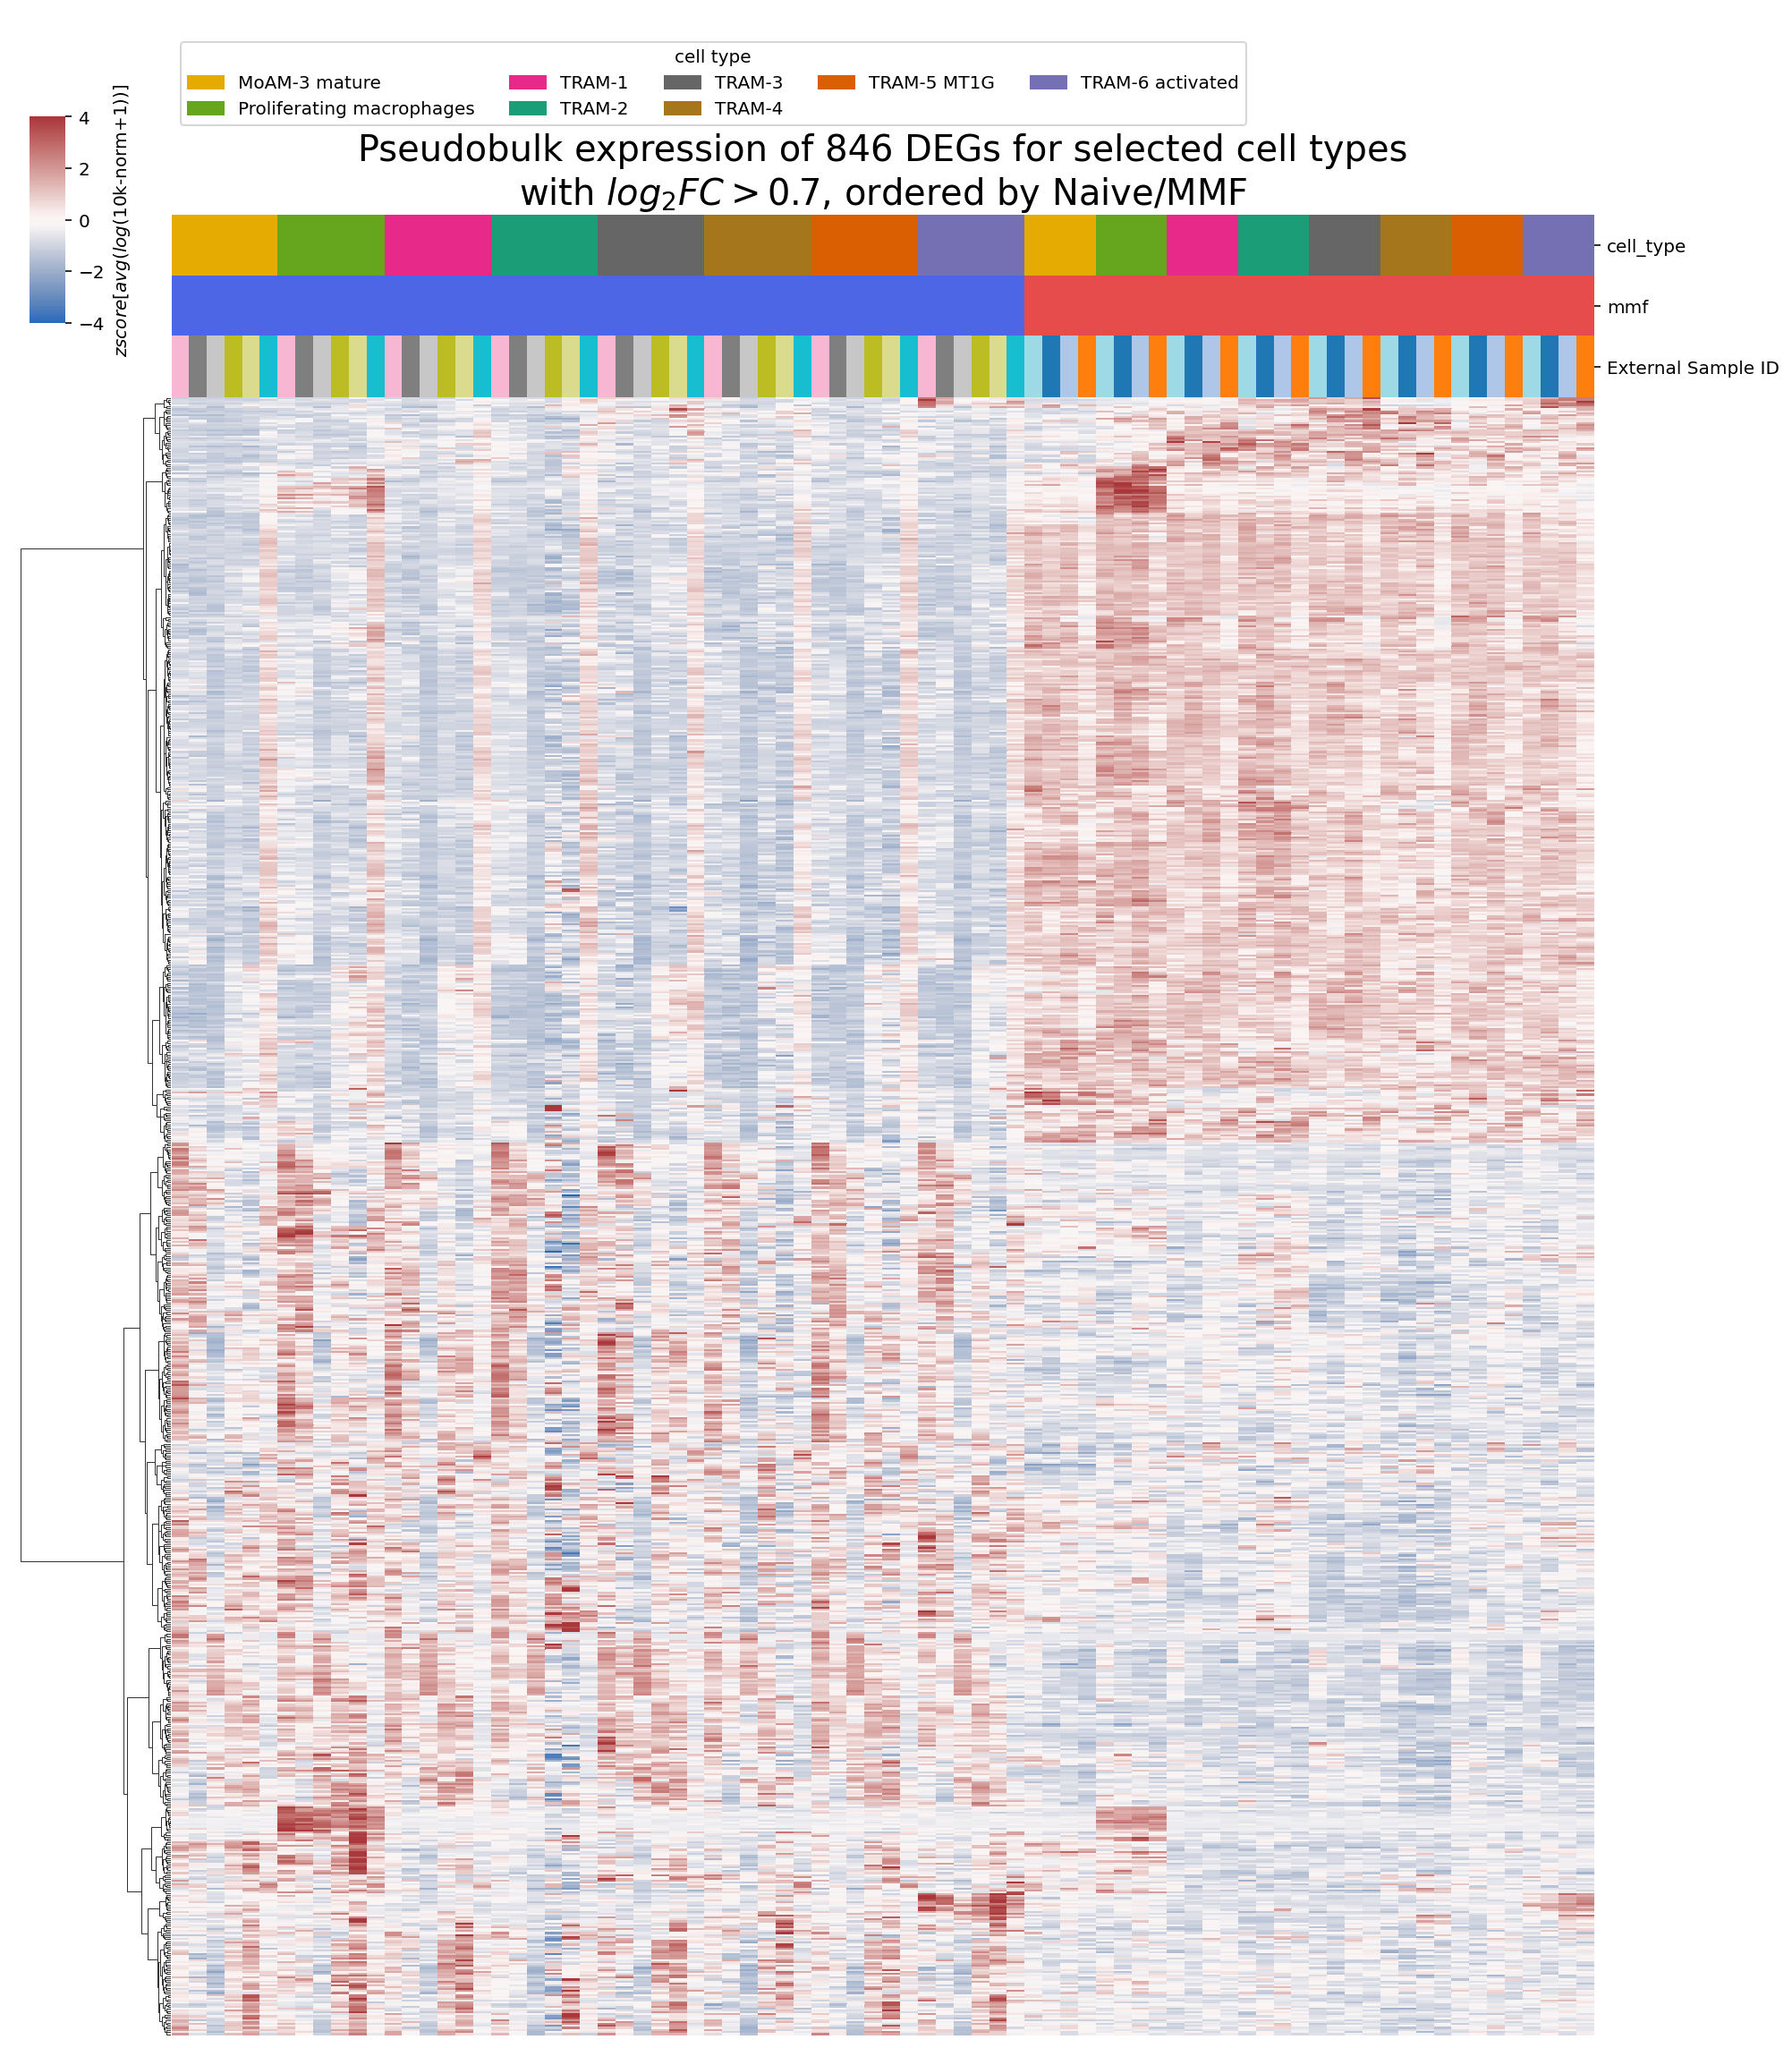

In [ ]:
cg = sns.clustermap(
    pseudobulk.loc[sample_order].T,
    figsize=(14, 16),
    method='ward',
    col_cluster=False,
    col_colors=col_colors_df.loc[sample_order],
    yticklabels=[],
    xticklabels=[],
    cmap='vlag',
    center=0,
    vmin=-4,
    vmax=4,
    cbar_kws={'label': '$zscore[avg(log($10k-norm$ + 1))]$'},
    cbar_pos=(0.02, 0.84, 0.02, 0.1),
    dendrogram_ratio=0.1,
)
cg.ax_col_colors.tick_params(left=False, labelleft=False, right=True, labelright=True)
cg.ax_col_colors.legend(
    handles=legend_handles['cell_type'],
    title='cell type',
    ncol=5,
    loc='upper left',
    bbox_to_anchor=(0, 2)
)
cg.ax_col_colors.set_title(
    f'Pseudobulk expression of {all_degs.size} DEGs for selected cell types\n'
    'with $log_2FC > 0.7$, ordered by Naive/MMF',
    size=20
)